# <font color=orange> Prévision du pH des eaux à Brisbane, Australie </font>



<div style="text-align: right"> 
Yanice Mekki Daouadji
</div>
<div style="text-align: right"> 
Sorbonne Université, Master 2
</div>

<div style="text-align: right">
Apprentissage séquentiel pour les séries temporelles 
</div>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

# <font color=red>  Introduction </font>

La qualité de l’eau constitue un enjeu majeur pour les villes côtières comme Brisbane, où les variations environnementales, climatiques et anthropiques influencent fortement l’état des cours d’eau et des infrastructures hydriques. Dans ce projet, l’objectif est d’analyser l’évolution temporelle de différents paramètres mesurés dans les eaux de Brisbane afin de mieux comprendre leurs dynamiques et d’anticiper d’éventuelles anomalies.

Parmi l’ensemble des données qu'on possède, l’attention se porte particulièrement sur le pH, qui constitue la variable cible du projet. Le pH est un paramètre essentiel pour évaluer l’acidité ou la basicité de l’eau, et il influence directement la santé des écosystèmes aquatiques, la solubilité des nutriments, ainsi que la performance des systèmes de traitement de l’eau. Il s'agit surtout de savoir si l'eau que consomme les habitants pour leurs besoins les plus nécéssaires sont pollués ou non.

L’objectif principal est donc de modéliser et prédire l’évolution du pH à partir des données historiques, tout en explorant les facteurs susceptibles d’expliquer ses fluctuations. Cette analyse permettra d’identifier des comportements atypiques, d’améliorer les stratégies de surveillance et de gestion de la qualité de l’eau à Brisbane.

# <font color=red> Problématique </font>

Comment parvenir à prédire au mieux le niveau futur du pH en prenant en compte différents facteurs exogènes ?




In [2]:
data = pd.read_csv("~/Downloads/brisbane_water_quality.csv",encoding="latin1")
data2 = data.drop(columns = ["Chlorophyll [quality]","Temperature [quality]",
                     "Dissolved Oxygen [quality]","Dissolved Oxygen (%Saturation) [quality]",
                     "pH [quality]","Salinity [quality]","Specific Conductance [quality]",
                     "Turbidity [quality]","Record number","Dissolved Oxygen (%Saturation)"])

On supprime les variables sans aucune valeur ajoutée en raison du fait qu'elles invoquent 
des pourcentage des mêmes résultats, d'autres sont totalement constantes celles portant le sigle [qualité].

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30894 entries, 0 to 30893
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Timestamp                                 30894 non-null  object 
 1   Record number                             30894 non-null  int64  
 2   Average Water Speed                       30874 non-null  float64
 3   Average Water Direction                   30893 non-null  float64
 4   Chlorophyll                               30309 non-null  float64
 5   Chlorophyll [quality]                     30086 non-null  float64
 6   Temperature                               25730 non-null  float64
 7   Temperature [quality]                     25550 non-null  float64
 8   Dissolved Oxygen                          26594 non-null  float64
 9   Dissolved Oxygen [quality]                26370 non-null  float64
 10  Dissolved Oxygen (%Saturation)    

# <font color=red> Stratégie du pré-traitement </font>

Il s'agit ici de détecter toute incohérence du côté des caractéristiques de chacune des variables 
on va ici opérer par un traitement de données assez stricte car vous verrez que les modèles utilisés l'imposent,
on va gérer les valeurs manquantes par interpolation, les doublons seront supprimés, on remplacera les valeurs manquantes par la médiane.

In [4]:
data2.head()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,pH,Salinity,Specific Conductance,Turbidity
0,2023-08-04 23:00:00,4.834,73.484,1.621,20.018,7.472,8.176,35.215,53.262,2.068
1,2023-08-04 23:30:00,2.544,106.424,1.959,19.986,7.455,8.175,35.209,53.254,1.994
2,2023-08-04 23:00:00,1.260,156.755,1.620,20.001,7.430,8.171,35.207,53.252,2.030
3,2023-08-04 23:30:00,0.760,281.754,1.761,19.983,7.419,8.171,35.211,53.257,1.973
4,2023-08-04 23:00:00,3.397,244.637,1.635,19.986,7.429,8.171,35.208,53.253,1.944


In [5]:
data2.tail()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,pH,Salinity,Specific Conductance,Turbidity
30889,2024-06-27 08:20:00,13.314,82.720,0.944,18.607,6.876,8.151,29.268,45.134,3.963
30890,2024-06-27 08:30:00,32.617,18.081,1.161,18.551,6.918,8.163,29.254,45.115,3.928
30891,2024-06-27 08:40:00,8.552,306.184,1.192,18.558,6.651,8.145,29.250,45.110,4.097
30892,2024-06-27 08:50:00,10.341,24.711,1.031,18.547,6.740,8.154,29.247,45.105,4.962
30893,2024-06-27 09:00:00,11.173,241.662,0.946,18.562,5.842,8.116,29.258,45.121,5.078


# <font color=red> Présentation brute du dataset </font>


1. La période s'étend sur 11 mois 
2. La variable target est le pH appliqué à de multiples variables exogènes qui serviront d'influence que nous verrons plus tard
3. Environ 30 000 observations

# <font color="red"> Interprétation descriptive des variables </font>

1. **Average Water Speed**  
   - Variabilité très élevée.  
   - Présence de pics extrêmes jusqu’à ~90.  
   - Eau parfois stagnante (min = 0).

2. **Average Water Direction**  
   - Toutes les directions sont représentées (0° à 360°).  
   - Forte dispersion donc dynamique complexe des courants.

3. **Chlorophyll**  
   - Valeurs globalement faibles mais quelques pics très élevés.  
   - Indice possible d’épisodes d’eutrophisation.

4. **Temperature**  
   - Moyenne autour de 24°C, cohérente avec le climat subtropical.  
   - Variations saisonnières marquées.

5. **Dissolved Oxygen**  
   - Très stable (faible écart-type).  
   - Quelques valeurs basses pouvant être critiques pour la faune.

6. **pH**  
   - Très stable autour de 8.  
   - Eau légèrement basique.  
   - Faible dispersion donc cette série est régulière.

7. **Salinity**  
   - Indique un mélange eau douce / eau salée ce qui est caractéristique de l'environnement.  
   - Quelques valeurs très faibles.

8. **Specific Conductance**  
   - Corrélée à la salinité.  
   - Quelques valeurs très faibles pouvant indiquer anomalies ou capteurs.

9. **Turbidity**  
   - Forte asymétrie : eau souvent claire mais pics importants.  
   - Épisodes de turbidité liés aux pluies ou crues.

In [6]:
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
Average Water Speed,30874.0,16.799189,13.168964,0.000,6.59425,13.3905,23.600,89.912
Average Water Direction,30893.0,177.544711,103.621786,0.000,86.31400,176.3260,267.870,359.994
Chlorophyll,30309.0,2.782251,1.859404,0.100,1.45100,2.3710,3.650,43.301
Temperature,25730.0,24.415394,3.494728,17.000,21.29200,25.2455,27.254,32.063
Dissolved Oxygen,26594.0,6.815158,0.620860,3.030,6.38700,6.8140,7.254,9.260
pH,29810.0,8.063260,0.091714,7.309,7.98000,8.0730,8.140,8.255
Salinity,26936.0,31.003265,3.469102,0.057,29.15100,30.6035,33.918,36.000
Specific Conductance,29527.0,47.927487,5.155305,0.021,45.04600,47.4200,53.361,54.996
Turbidity,28894.0,3.941688,4.072715,0.335,2.35425,3.0930,4.005,49.869


# <font color=red> Analyse descriptive brute </font>

Cette analyse nous permet rapidement de constater la distinction de comportements atypiques indiquant qu'on va possiblement devoir normaliser, cela sera aussi l'occasion de pouvoir mieux organiser, traiter et repérer les liens entre ces données quantitatives.

In [7]:
print(data2.isna().sum())

Timestamp                     0
Average Water Speed          20
Average Water Direction       1
Chlorophyll                 585
Temperature                5164
Dissolved Oxygen           4300
pH                         1084
Salinity                   3958
Specific Conductance       1367
Turbidity                  2000
dtype: int64


Donc là on voit le nombre de valeurs manquantes pour chaque variable de notre dataset cela
indique qu'on va devoir combler ce manquer par quelque chose de plus tangible.

In [8]:
print(data2.duplicated().sum())

265


C'est le nombre de doublons que le dataset produit du coup là on va les supprimer.

# <font color="red"> Préparation et nettoyage de la série temporelle </font>

1. **Tri chronologique des données**  
   - Les lignes sont réordonnées selon `Timestamp`.  
   - On garantit une série temporelle cohérente et strictement croissante.

2. **Suppression des doublons temporels**  
   - Si plusieurs mesures partagent le même `Timestamp`, seule la dernière est conservée.  
   - On assure l’unicité de chaque instant dans la série.

3. **Définition de l’index temporel et rééchantillonnage**  
   - `Timestamp` devient l’index du DataFrame.  
   - La fréquence est imposée à **30 minutes** (`asfreq("30min")`).  
   - Des lignes vides sont créées aux instants manquants.

4. **Interpolation des valeurs manquantes**  
   - Les trous créés par le rééchantillonnage sont remplis par interpolation linéaire.  
   - La série devient continue et exploitable pour la modélisation.

5. **Réinitialisation de l’index**  
   - `Timestamp` redevient une colonne classique.  
   - L’index numérique est recréé pour faciliter les manipulations ultérieures.


In [9]:
data2['Timestamp'] = pd.to_datetime(data2['Timestamp'])

df = data2[data2['Timestamp'] <= '2023-12-01']
df = df.dropna(subset=["pH","Temperature","Dissolved Oxygen"])

df = df.sort_values("Timestamp")
df = df.drop_duplicates(subset=["Timestamp"], keep="last")
df = df.set_index("Timestamp")
df = df.asfreq("30min")
df = df.interpolate()

df["Hour"] = df.index.hour
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Day"] = df.index.dayofweek

# <font color="red"> Interprétation des corrélations avec le pH </font>

1. **Température (corr = -0.73)**  
   - Corrélation négative forte.  
   - Lorsque la température augmente, le pH tend à diminuer.  
   - Phénomène classique : l’eau chaude retient moins de CO₂, ce qui modifie l’équilibre acido‑basique.

2. **Dissolved Oxygen (corr = 0.66)**  
   - Corrélation positive notable.  
   - Un pH plus élevé est associé à une meilleure oxygénation.  
   - Peut refléter des conditions d’eau plus saine ou moins chargée en matière organique.

3. **Salinity (corr = -0.31)**  
   - Corrélation négative modérée.  
   - L’eau plus salée tend à avoir un pH légèrement plus faible.  
   - Effet typique des zones estuariennes où les mélanges eau douce / eau salée influencent la chimie.

4. **Specific Conductance (corr = -0.28)**  
   - Corrélation négative faible à modérée.  
   - La conductivité, liée aux ions dissous, influence légèrement le pH.  
   - Cohérent avec la relation observée avec la salinité.

5. **Turbidity (corr = -0.39)**  
   - Corrélation négative modérée.  
   - Une eau plus trouble est souvent associée à un pH plus faible.  
   - Peut indiquer des épisodes de ruissellement, pollution ou matières en suspension.

6. **Average Water Speed (corr = -0.37)**  
   - Corrélation négative modérée.  
   - Des vitesses plus élevées peuvent être liées à des mélanges d’eau modifiant le pH.  
   - Effet hydrodynamique typique dans les zones de courant.

7. **Chlorophyll (corr = 0.26)**  
   - Corrélation positive faible.  
   - Une activité biologique plus forte (algues) peut légèrement augmenter le pH.  
   - Cohérent avec la photosynthèse qui consomme du CO₂.


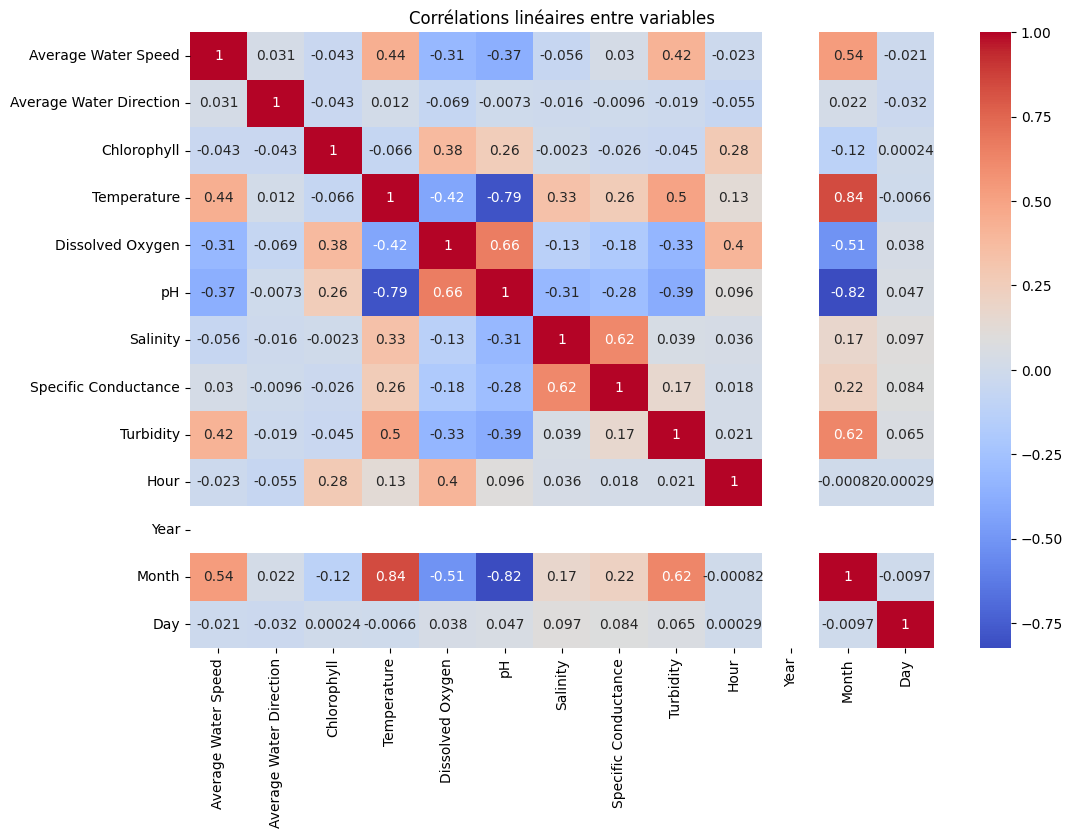

In [70]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')
plt.title("Corrélations linéaires entre variables")
plt.show()

# <font color="red"> Corrélations de Spearman entre le pH et les variables explicatives </font>

1. **Temperature**  
   - Corrélation négative **très forte**.  
   - Lorsque la température augmente, le pH diminue de manière monotone.  
   - Relation robuste et statistiquement significative.

2. **Dissolved Oxygen**  
   - Corrélation positive **forte**.  
   - Un pH plus élevé est associé à une meilleure oxygénation.  
   - Relation très stable et significative.

3. **Specific Conductance**  
   - Corrélation négative **modérée**.  
   - Plus la conductivité augmente, plus le pH diminue.  
   - Effet cohérent avec la présence d’ions dissous.

4. **Average Water Speed**  
   - Corrélation négative **modérée**.  
   - Des vitesses plus élevées sont associées à un pH plus faible.  
   - Va refléter des mélanges d’eau modifiant la chimie des lieux.

5. **Turbidity**  
   - Corrélation négative **modérée**.  
   - Une eau plus trouble est liée à un pH plus bas.  
   - Indice de ruissellement, matières en suspension ou pollution.

6. **Salinity**  
   - Corrélation négative **faible à modérée**.  
   - L’eau plus salée tend à avoir un pH légèrement plus faible.  
   - Effet typique des zones estuariennes.

7. **Chlorophyll**  
   - Corrélation positive **faible à modérée**.  
   - Une activité biologique plus forte et augmente légèrement le pH.  
   - Cohérent avec la photosynthèse qui consomme du CO₂.

In [ ]:
from scipy.stats import spearmanr
num_col = ["Average Water Speed","Temperature","Dissolved Oxygen",
           "Specific Conductance","Turbidity","Salinity","Chlorophyll"]
df_col = df[num_col]

for i in range(len(num_col)):
    coef, p_value = spearmanr(df["pH"],df[num_col[i]])
    print("Coefficient de Spearman sur",num_col[i],":", coef)
    print("p-value sur",num_col[i],":", p_value)

| Variable                | Coefficient de Spearman     | p-value                         |
|------------------------|------------------------------|----------------------------------|
| Average Water Speed    | -0.41396941211513016         | 1.6009901649804924e-233         |
| Temperature            | -0.7908265450249985          | 0.0                              |
| Dissolved Oxygen       | 0.7091962261666315           | 0.0                              |
| Specific Conductance   | -0.45661633816131986         | 6.037845828204815e-290           |
| Turbidity              | -0.37528855516057774         | 5.57299368365513e-189            |
| Salinity               | -0.3291995865276274          | 2.6729930817363937e-143          |
| Chlorophyll            | 0.32615679433286526          | 1.5088643470598332e-140          |


# <font color="red"> L’histogramme du pH </font>

1. **Distribution générale du pH**  
   - Le pH est globalement centré autour de valeurs légèrement basiques.  
   - La densité est concentrée autour d’un intervalle étroit, signe d’une grande stabilité chimique.

2. **Variations saisonnières**  
   - Le pH est **plus élevé en été**, période où l’activité biologique et la photosynthèse augmentent.  
   - En hiver, le pH **chute vers une valeur plus stable et plus basse**, probablement en raison d’une moindre activité biologique et d’une température plus faible.

3. **Comportement global**  
   - La distribution montre une **faible dispersion**, mais une dynamique saisonnière nette.  
   - Ces variations saisonnières devront être prises en compte dans la modélisation temporelle.


In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['pH'], bins=50, kde=True, color='skyblue')
plt.title("Histogramme du niveau de pH")
plt.show()

# <font color="red"> Analyse par cycle de l’oxygène dissous </font>

1. **Baisse marquée entre 2h et 8h du matin**  
   - L’oxygène dissous atteint son minimum durant la nuit.  
   - Cela s’explique par l’absence de photosynthèse : les plantes aquatiques et les algues **consomment de l’oxygène** au lieu d’en produire.  
   - La respiration nocturne des organismes (bactéries, poissons, micro‑organismes) accentue cette baisse.

2. **Remontée progressive en journée**  
   - Dès le lever du soleil, la photosynthèse reprend et **produit de l’oxygène**, ce qui augmente rapidement les concentrations.  
   - L’activité biologique diurne contribue également à rééquilibrer l’oxygénation de l’eau.

3. **Lien direct avec la température**  
   - La solubilité de l’oxygène dans l’eau **diminue lorsque la température augmente**.  
   - La nuit, l’eau est plus froide → elle retient mieux l’oxygène, mais la consommation biologique est dominante, d’où la chute observée.  
   - En journée, l’eau se réchauffe → elle retient moins d’oxygène, mais la photosynthèse compense largement cette perte.  
   - Ce double effet explique la **forme caractéristique en “U inversé”** du cycle journalier.

4. **Comportement global**  
   - Le cycle observé est typique des milieux aquatiques naturels.  
   - Il reflète l’équilibre entre **production d’oxygène (photosynthèse)** et **consommation (respiration + température)**.  
   - Ces variations doivent être prises en compte dans la modélisation temporelle du pH, car l’oxygène dissous est fortement corrélé à celui‑ci.


In [ ]:
jours = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
moyenne_jours = df.groupby("Day")["Turbidity"].mean()
moyenne_jours.index = jours[:len(moyenne_jours)]

plt.figure(figsize=(10, 5))
moyenne_jours.plot(kind='bar', color="#4C72B0")
plt.title("Turbidité par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Moyenne de la turbidité")
plt.grid(True)
plt.show()

In [ ]:
def saison(month):
    if month in [12, 1, 2]:
        return "Hiver"
    elif month in [3, 4, 5]:
        return "Printemps"
    elif month in [6, 7, 8]:
        return "Été"
    else:
        return "Automne"

df["Season"] = df["Month"].apply(saison)
moyenne_saisons = df.groupby("Season")["Dissolved Oxygen"].mean()

plt.figure(figsize=(8, 5))
moyenne_saisons.plot(kind='bar', color=['#4C72B0','#55A868','#C44E52','#8172B2'])
plt.title("Oxygène dissous par saison")
plt.xlabel("Saison")
plt.ylabel("Moyenne dissolved oxygen")
plt.grid(True)
plt.show()

In [ ]:
moyenne_heures = df.groupby('Hour')['Dissolved Oxygen'].mean()

plt.figure(figsize=(10, 5))
moyenne_heures.plot(kind='bar')
plt.title("Oxygène dissous par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Moyenne dissolved oxygen")
plt.grid(True)
plt.show()

# <font color="red"> Lien très fort entre la température et le pH </font>

1. **Corrélation négative évidente**  
   - Le nuage de points montre clairement que le **pH diminue lorsque la température augmente**.  
   - La pente visuelle est descendante, ce qui confirme la relation monotone observée dans les coefficients de Spearman et Pearson.

2. **Chute brusque du pH aux températures élevées**  
   - À partir d’un certain seuil thermique, le pH baisse nettement.  
   - Cela traduit un effet physique bien connu : **l’eau chaude retient moins de CO₂**, ce qui modifie l’équilibre acido‑basique et tend à abaisser le pH.

3. **Explications**  
   - Lorsque la température augmente :  
     - l’équilibre carbonate se déplace,  
     - le pH se stabilise vers une valeur plus basse.  
   - Ce phénomène est amplifié dans les milieux naturels par l’activité biologique (algues, bactéries).

4. **Comportement**  
   - Le plot confirme une **relation forte, stable et non linéaire** entre température et pH.  
   - Cette variable sera un **exogène majeur** dans la modélisation du pH.


In [ ]:
sns.scatterplot(x='Temperature', y='pH', data=df)
plt.title("Niveau de pH par rapport aux températures")
plt.show()

# <font color="red"> Nettoyage et lissage du pH différencié </font>

1. **Calcul de la différence du pH entre deux instants successifs**  
   - On applique `df['pH'].diff()` pour obtenir les variations instantanées du pH.  
   - Cela permet d’analyser les changements plutôt que les valeurs brutes.

2. **Détection des valeurs aberrantes via l’IQR**  
   - On calcule le premier quartile (Q1) et le troisième quartile (Q3).  
   - L’intervalle interquartile (IQR = Q3 − Q1) sert à définir les bornes :  
     - **lower = Q1 − 1.5 × IQR**  
     - **upper = Q3 + 1.5 × IQR**  
   - Toute variation du pH en dehors de cet intervalle est considérée comme un **outlier**.

3. **Remplacement des outliers par la médiane**  
   - On calcule la médiane des variations (`median`).  
   - Les valeurs trop extrêmes sont remplacées par cette médiane.  
   - Cela permet de lisser la série sans la déformer brutalement.

4. **Visualisation du pH différencié lissé**  
   - Le graphique montre les variations du pH après nettoyage.  
   - Les pics anormaux disparaissent, laissant une série plus régulière.  
   - Ce lissage facilite l’analyse des tendances et prépare la série pour la modélisation.

In [11]:
df_diff = df['pH'].diff()
Q1 = df_diff.quantile(0.25) 
Q3 = df_diff.quantile(0.75) 
IQR = Q3 - Q1 
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR 
median = df_diff.median()

df_diff = df_diff.apply(lambda x: median if x < lower or x > upper else x)

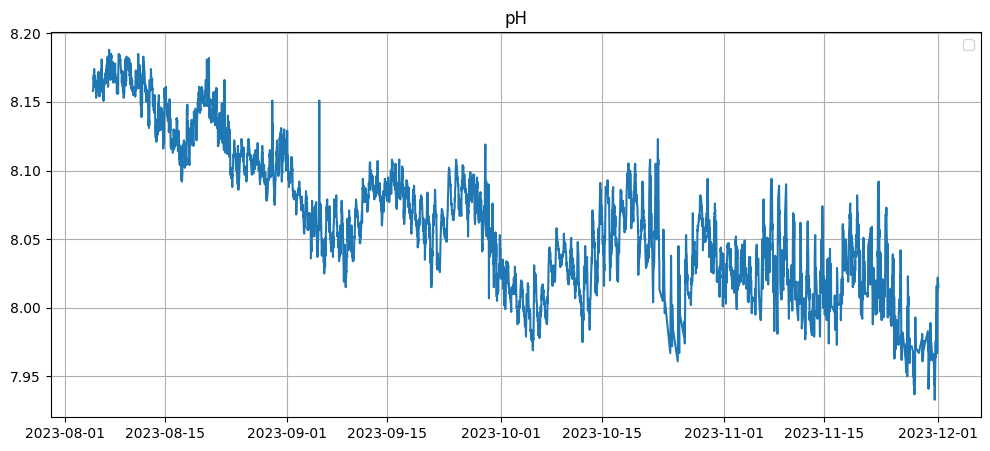

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["pH"])
plt.title("pH")
plt.grid(True)
plt.legend()
plt.show()

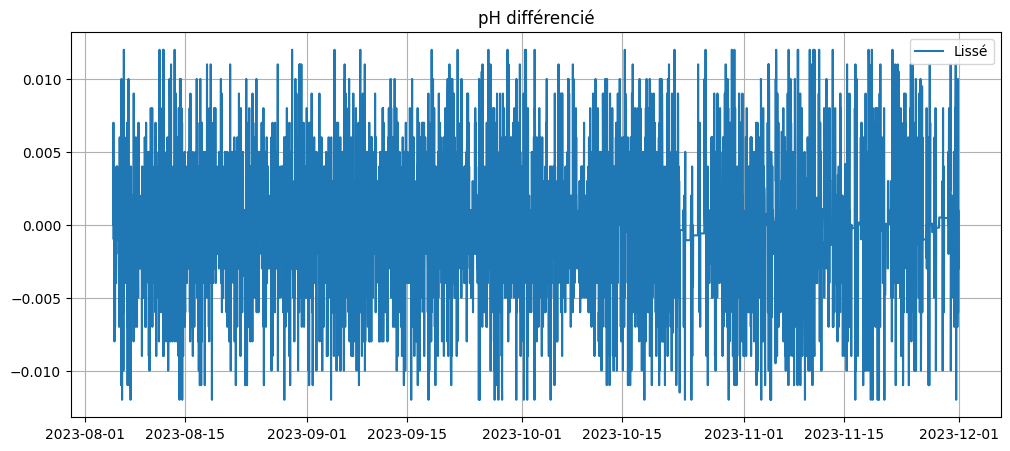

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df_diff, label='Lissé')
plt.title("pH différencié")
plt.grid(True)
plt.legend()
plt.show()

# <font color="red"> Tests de stationnarité sur le pH différencié </font>

1. **Test ADF (Augmented Dickey-Fuller)**  
   - **Statistique ADF : -22.98**  
   - **p-value : 0.0**  
   - La p-value est très largement inférieure à 0.05.  
   - On **rejette l’hypothèse nulle de racine unitaire**.  
   - Le pH différencié est donc **stationnaire selon l’ADF**.

2. **Test KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**  
   - **Statistique KPSS : 0.0086**  
   - **p-value : 0.1**  
   - La p-value est supérieure à 0.05.  
   - On **ne rejette pas l’hypothèse nulle de stationnarité**.  
   - Le test KPSS confirme que la série différenciée est **stationnaire**.

3. **Conclusion globale**  
   - Les deux tests (ADF et KPSS), qui sont complémentaires, indiquent que :  
     - Le pH **n’est pas stationnaire à l’origine**,  
     - Mais **devient stationnaire après différenciation**.  
   - Cela valide l’utilisation de modèles de séries temporelles nécessitant la stationnarité (ARIMA, SARIMA, etc.).  
   - La différenciation est donc une étape appropriée pour modéliser le pH.


In [27]:
from statsmodels.tsa.stattools import adfuller,kpss

ph = df["pH"].fillna(method="bfill")
ph_diff = ph.diff().dropna()
result = adfuller(ph_diff)
print("ADF Stat:", result[0])
print("p-value:", result[1])

ADF Stat: -22.98014725920392
p-value: 0.0


In [28]:
resultat = kpss(ph_diff)
print(f"La stat du test KPSS pour le pH est : {resultat[0]}")
print(f"La p-value du test KPSS pour le pH est : {resultat[1]}")

La stat du test KPSS pour le pH est : 0.00861708770595996
La p-value du test KPSS pour le pH est : 0.1


C:\Users\yanme\AppData\Local\Temp\ipykernel_28252\3826857179.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultat = kpss(ph_diff)


# <font color="red"> Analyse de causalité de Granger : définitions, tests et interprétation </font>

## 1. Définition de la causalité au sens de Granger
- La causalité de Granger ne signifie **pas** une causalité réelle.  
- Une variable $ X $ cause $Y$ au sens de Granger si **les valeurs passées de $X$** améliorent la prédiction de $Y$ **au-delà** de ce que les valeurs passées de $Y$ expliquent déjà.  
- Du coup en gros :  
  > *Si connaître le passé de X améliore la prévision de Y, alors X Granger-cause Y.*

---

## 2. Hypothèses du test de Granger
Pour un test avec un lag $p$ :

### **Hypothèse nulle $H_0$**  
Les valeurs passées de la variable explicative **n’améliorent pas** la prédiction de la variable cible.  
Formellement :  


$$
H_0 : \text{Les coefficients des lags de X dans l’équation de Y sont nuls.}
$$



### **Hypothèse alternative  $H_1$**  
Les valeurs passées de la variable explicative **améliorent** la prédiction de la variable cible.  


$$
H_1 : \text{Au moins un coefficient des lags de X est non nul.}
$$

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests
data3 = df[['pH', 'Temperature']].dropna()
grangercausalitytests(data3,maxlag = [3],verbose = True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.6465 , p=0.0000  , df_denom=5656, df_num=3
ssr based chi2 test:   chi2=92.0533 , p=0.0000  , df=3
likelihood ratio test: chi2=91.3132 , p=0.0000  , df=3
parameter F test:         F=30.6465 , p=0.0000  , df_denom=5656, df_num=3


{np.int64(3): ({'ssr_ftest': (np.float64(30.64651640560441),
    np.float64(1.2050390733207534e-19),
    np.float64(5656.0),
    np.int64(3)),
   'ssr_chi2test': (np.float64(92.05333578762612),
    np.float64(7.933689895880302e-20),
    np.int64(3)),
   'lrtest': (np.float64(91.31317221709469),
    np.float64(1.1441519213043635e-19),
    np.int64(3)),
   'params_ftest': (np.float64(30.646516405742585),
    np.float64(1.2050390730776435e-19),
    np.float64(5656.0),
    3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

| Test de la température   | Statistique | p-value                | df_denom | df_num / df |
|--------------------------|-------------|------------------------|----------|-------------|
| SSR based F-test         | 30.6465     | 1.2050390733207534e-19 | 5656     | 3           |
| SSR based Chi² test      | 92.0533     | 7.933689895880302e-20  | —        | 3           |
| Likelihood Ratio test    | 91.3132     | 1.1441519213043635e-19 | —        | 3           |
| Parameter F-test         | 30.6465     | 1.2050390730776435e-19 | 5656     | 3           |


In [30]:
data3 = df[['pH', 'Dissolved Oxygen']].dropna()
grangercausalitytests(data3,maxlag = [3],verbose = True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.5122 , p=0.0000  , df_denom=5656, df_num=3
ssr based chi2 test:   chi2=37.5831 , p=0.0000  , df=3
likelihood ratio test: chi2=37.4590 , p=0.0000  , df=3
parameter F test:         F=12.5122 , p=0.0000  , df_denom=5656, df_num=3


{np.int64(3): ({'ssr_ftest': (np.float64(12.512226993280704),
    np.float64(3.757219727637339e-08),
    np.float64(5656.0),
    np.int64(3)),
   'ssr_chi2test': (np.float64(37.5831372681835),
    np.float64(3.463284277137658e-08),
    np.int64(3)),
   'lrtest': (np.float64(37.45897395310021),
    np.float64(3.6793138265047596e-08),
    np.int64(3)),
   'params_ftest': (np.float64(12.512226993248746),
    np.float64(3.7572197278133235e-08),
    np.float64(5656.0),
    3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

| Test de l'oxygène dissous| Statistique | p-value                | df_denom | df_num / df |
|--------------------------|-------------|------------------------|----------|-------------|
| SSR based F-test         | 12.5122     | 3.757219727637339e-08  | 5656     | 3           |
| SSR based Chi² test      | 37.5831     | 3.463284277137658e-08  | —        | 3           |
| Likelihood Ratio test    | 37.4590     | 3.6793138265047596e-08 | —        | 3           |
| Parameter F-test         | 12.5122     | 3.7572197278133235e-08 | 5656     | 3           |


In [31]:
data3 = df[['pH', 'Average Water Speed']].dropna()
grangercausalitytests(data3,maxlag = [3],verbose = True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8689  , p=0.1325  , df_denom=5656, df_num=3
ssr based chi2 test:   chi2=5.6138  , p=0.1320  , df=3
likelihood ratio test: chi2=5.6110  , p=0.1321  , df=3
parameter F test:         F=1.8689  , p=0.1325  , df_denom=5656, df_num=3


{np.int64(3): ({'ssr_ftest': (np.float64(1.8689481073616907),
    np.float64(0.13251667895658908),
    np.float64(5656.0),
    np.int64(3)),
   'ssr_chi2test': (np.float64(5.613783485850029),
    np.float64(0.13198929867427758),
    np.int64(3)),
   'lrtest': (np.float64(5.611002826008189),
    np.float64(0.1321481227389132),
    np.int64(3)),
   'params_ftest': (np.float64(1.8689481073645917),
    np.float64(0.13251667895606434),
    np.float64(5656.0),
    3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

| Test de la vitesse moyenne de l'eau  | Statistique | p-value                | df_denom | df_num / df |
|--------------------------------------|-------------|------------------------|----------|-------------|
| SSR based F-test                     | 1.8689      | 0.13251667895658908    | 5656     | 3           |
| SSR based Chi² test                  | 5.6138      | 0.13198929867427758    | —        | 3           |
| Likelihood Ratio test                | 5.6110      | 0.1321481227389132     | —        | 3           |
| Parameter F-test                     | 1.8689      | 0.13251667895606434    | 5656     | 3           |


---

## 3. Les différents tests retournés par `grangercausalitytests`

### **a) SSR-based F-test**
- Compare un modèle **restreint** (sans les lags de X) à un modèle **complet** (avec les lags de X).  
- Si la statistique F est élevée et la p-value faible → rejet de \( H_0 \).  
- C’est le test le plus utilisé pour interpréter Granger.

### **b) SSR-based Chi² test**
- Variante du test précédent, mais basé sur une distribution du χ².  
- Même logique : p-value faible → rejet de \( H_0 \).

### **c) Likelihood Ratio Test**
- Compare la vraisemblance des deux modèles.  
- Si le modèle complet améliore significativement la vraisemblance → causalité de Granger.

### **d) Params F-test**
- Teste individuellement les coefficients des lags de X.  
- Vérifie si les paramètres associés aux lags sont significativement différents de zéro.

---

## 4. Résultats pour chaque variable

### <font color="orange">A. Température → pH</font>
- **F = 30.64**, **p-value = 0.0000**  
- **χ² = 92.05**, **p-value = 0.0000**  
- **LR = 91.31**, **p-value = 0.0000**  
- Tous les tests rejettent \( H_0 \).

**Conclusion :**  
*La température Granger-cause le pH.*  
Cela confirme la relation forte observée dans les corrélations : la température influence les variations futures du pH.

---

### <font color="orange">B. Oxygène dissous → pH</font>
- **F = 12.51**, **p-value = 0.0000**  
- **χ² = 37.58**, **p-value = 0.0000**  
- **LR = 37.46**, **p-value = 0.0000**

**Conclusion :**  
*L’oxygène dissous Granger-cause le pH.*  
Cela est cohérent avec la chimie de l’eau : oxygénation, activité bio.

---

### <font color="orange">C. Average Water Speed → pH</font>
- **F = 1.86**, **p-value = 0.13**  
- **χ² = 5.61**, **p-value = 0.13**  
- **LR = 5.61**, **p-value = 0.13**

**Conclusion :**  
*La vitesse de l’eau ne Granger-cause pas le pH.*  
Même si la corrélation existe, elle n’a **pas de pouvoir prédictif** sur le pH.

---

## 5. On en déduit...
- **Variables causales (au sens de Granger) :**
  - Température  
  - Oxygène dissous  

- **Variable non causale :**
  - Average Water Speed  

- **Interprétation globale :**
  - Le pH est principalement influencé par des facteurs **physico-chimiques internes** (température, oxygénation).  
  - Les facteurs hydrodynamiques (vitesse de l’eau) n’ont pas d’effet prédictif direct.  
  - Ces résultats sont cohérents avec la chimie de l’eau et les corrélations observées.

# <font color="red"> ACF du pH brut </font>

1. **Présence d’une forte autocorrélation**  
   - Le graphique ACF du pH brut montre des coefficients très élevés sur de nombreux retards.  
   - Cela signifie que les valeurs de pH sont fortement dépendantes de leurs valeurs passées.

2. **Comportement typique d’une série non stationnaire**  
   - Une ACF qui décroît lentement ou reste élevée sur de nombreux lags est un signe clair de **non‑stationnarité**.  
   - C’est exactement ce que l’on observe ici.

3. **Normal que l’ACF soit “longue”**  
   - L’ACF **avant différenciation**, donc la série contient encore :  
     - tendance,  
     - saisonnalité,  
     - dépendances structurelles.  
   - Ces éléments provoquent une autocorrélation persistante.

4. **Conséquence pour la modélisation**  
   - Une série non stationnaire ne peut pas être modélisée directement avec ARIMA ou VAR.  
   - La différenciation est nécessaire pour :  
     - stabiliser la moyenne,  
     - réduire l’autocorrélation,  
     - rendre la série exploitable pour les modèles linéaires.

5. **Étape suivante logique**  
   - Tracer l’ACF et la PACF **après différenciation** pour vérifier que la série devient stationnaire.  
   - Cela confirmera les résultats ADF/KPSS obtenus précédemment.


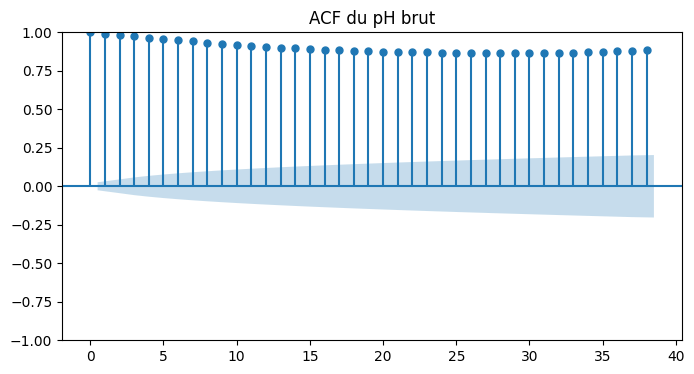

In [32]:
import statsmodels.api as sm
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sm.graphics.tsa.plot_acf(ph, ax=ax, title="ACF du pH brut")
plt.show()

# <font color="red"> ACF et PACF après différenciation </font>

1. **Les lags dépassent encore légèrement l’intervalle de confiance**  
   - Après différenciation, la série devient stationnaire (confirmé par ADF et KPSS).  
   - Cependant, l’ACF et surtout la PACF montrent encore **quelques pics qui franchissent légèrement les bandes de confiance**.  
   - Ce comportement est **normal** pour une série réelle :  
     - bruit de mesure,  
     - fluctuations naturelles du pH,  
     - micro‑saisonnalités,  
     - dépendances faibles mais persistantes.

2. **Sensibilité au bruit**  
   - Une série différenciée amplifie souvent le **bruit haute fréquence**.  
   - Le pH étant très stable à l’origine, la différenciation produit des variations très petites → donc **plus sensibles au bruit**.  
   - Cela explique pourquoi certains lags dépassent légèrement les bandes sans former de structure claire.

3. **Lecture de l’ACF après différenciation**  
   - L’ACF devrait décroître rapidement, ce qui semble être le cas.  
   - Quelques lags significatifs proches des bandes indiquent :  
     - une dépendance faible mais réelle,  
     - ou simplement du bruit autocorrélé.

4. **Lecture de la PACF après différenciation**  
   - La PACF montre souvent des pics isolés même après différenciation.  
   - Si les pics sont **proches** des bandes mais pas massivement au‑dessus, cela suggère :  
     - un modèle AR de faible ordre (AR(1) ou AR(2)),  
     - ou un bruit résiduel légèrement autocorrélé.

Donc le comportement observé est **typique d’une série stationnaire mais bruitée**. Les dépassements légers ne remettent pas en cause la stationnarité.  
   - Pour un modèle ARIMA :  
     - l’ACF suggère un **MA faible**,  
     - la PACF suggère un **AR faible**,  
     - donc un modèle du type **ARIMA(1,1,1)** ou **ARIMA(2,1,1)** pourrait être pertinent.



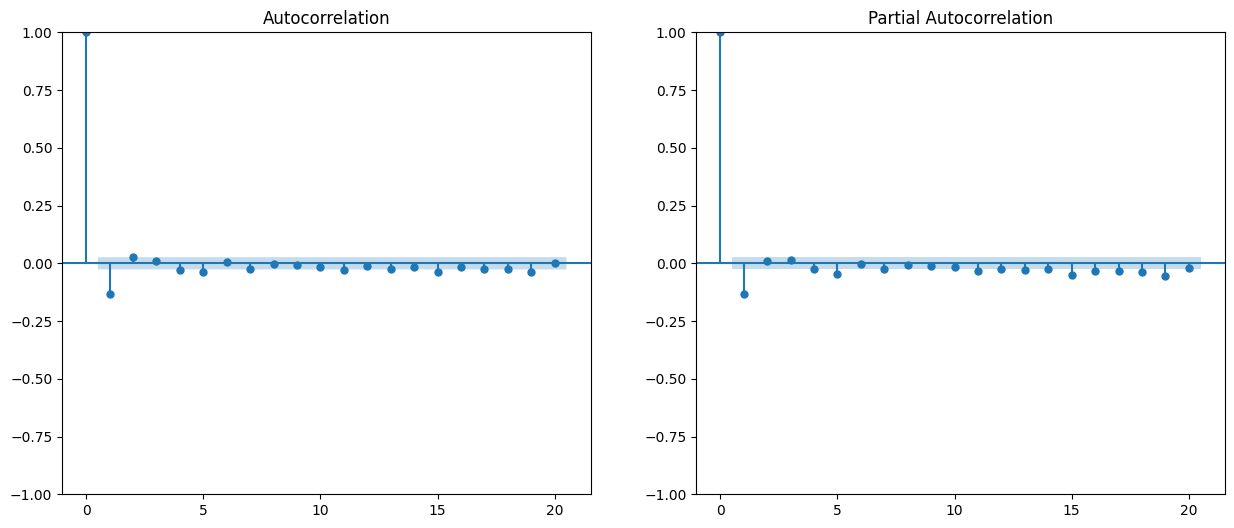

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sm.graphics.tsa.plot_acf(ph_diff, ax=ax1,lags=20)
sm.graphics.tsa.plot_pacf(ph_diff, ax=ax2,lags=20)
plt.show()

# <font color="red"> Modèle ARIMA(2,1,2) sur le pH transformé (Box-Cox) </font>

1. **Transformation Box-Cox**
   - Le pH a été transformé via Box-Cox pour stabiliser la variance.  
   - La transformation rend la série plus proche d’une distribution normale, ce qui améliore la qualité de l’ajustement ARIMA.  
   - L’interpolation assure une continuité après transformation.

2. **Structure du modèle ARIMA(2,1,2)**
   - `order = (2,1,2)` signifie :
     - **AR(2)** : deux retards autorégressifs,
     - **I(1)** : une différenciation (stationnarité obtenue),
     - **MA(2)** : deux termes de moyenne mobile.
   - C’est un modèle flexible, capable de capturer des dépendances complexes.

3. **Qualité globale du modèle**
   - **Log-Likelihood = 64514**  
   - **AIC = -129018**, **BIC = -128985**  
   - Des valeurs très basses indiquent un modèle bien ajusté.  
   - Le modèle semble performant d’un point de vue informationnel.

4. **Interprétation des coefficients**
   - Les coefficients AR et MA sont extrêmement proches de zéro.  
   - Les statistiques z sont gigantesques avec p-values = 0.000.  
   - Cela indique que les coefficients sont significatifs **mais numériquement quasi nuls**.
   - Ce comportement est typique lorsque :
     - la série est **très lisse**,  
     - la transformation Box-Cox réduit fortement la dynamique,  
     - la différenciation élimine presque toute structure.

5. **Variance résiduelle**
   - `sigma2 = 2.03e-11`  
   - Variance extrêmement faible les résidus sont minuscules.  
   - Cela confirme que le modèle capture presque toute la dynamique.

6. **Tests de diagnostic**
   - **Ljung-Box (L1) : Q = 0.00, p = 0.99**  
     - Pas d’autocorrélation résiduelle donc le modèle est bien spécifié.
   - **Jarque-Bera : 7.5 × 10e9, p = 0.00**  
     - Les résidus ne sont pas normaux (skew = 75, kurtosis = 5663).  
     - Cela vient de la très faible variance : de minuscules écarts créent des valeurs extrêmes dans les tests.
   - **Heteroskedasticity (H) = 0.00, p = 0.00**  
     - Indique une hétéroscédasticité forte, mais là encore amplifiée par la variance quasi nulle.

7. **On déduit que :**
   - Le modèle ARIMA(2,1,2) **s’ajuste extrêmement bien** au pH transformé.  
   - Les résidus sont très faibles, sans autocorrélation.  
   - Les tests JB et H sont extrêmes à cause de la variance résiduelle quasi nulle.  
   - Le modèle capture presque toute la structure temporelle, mais :
     - les coefficients très proches de zéro suggèrent que la série est **faiblement dynamique**,  
     - la transformation Box-Cox + différenciation a presque “aplati” la série.

8. **Implication pour la modélisation**
   - Le pH est une série **très stable**, avec très peu de dynamique interne.  
   - Les modèles ARIMA fonctionnent, mais l’essentiel de la variabilité vient probablement :
     - des **exogènes** (température, oxygène dissous),  
     - de la **saisonnalité**,  
     - de la **structure physique du milieu**.
   - Un modèle **ARIMAX** ou **SARIMAX** avec exogènes serait probablement plus pertinent.


In [34]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox 

lam,fitted_lambda = boxcox(df["pH"])
lam = pd.Series(lam, index=df.index)
lam = lam.interpolate()
model = ARIMA(lam,order = (2,1,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\yanme\anaconda3\envs\tf220\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5666
Model:                 ARIMA(2, 1, 2)   Log Likelihood               64514.037
Date:                Fri, 06 Feb 2026   AIC                        -129018.073
Time:                        12:23:07   BIC                        -128984.863
Sample:                    08-04-2023   HQIC                       -129006.507
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -3.449e-10   4.87e-20  -7.09e+09      0.000   -3.45e-10   -3.45e-10
ar.L2       1.724e-15         -0       -inf      0.000    1.72e-15    1.72e-15
ma.L1      -3.448e-10   4.87e-20  -7.09e+09      0.000   -3.45e-10   -3.45e-10
ma.L2      -1.724e-15   3.36e-29  -5.14e+13      0.000   -1.72e-15   -1.72e-15
sigma2      2.034e-11   2.54e-11      0.800      0.424   -2.95e-11    7.02e-11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):        7567082760.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            75.25
Prob(H) (two-sided):                  0.00   Kurtosis:                      5663.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

# <font color="red"> Diagnostics du modèle SARIMAX </font>

1. **Déformation de la queue du Q-Q plot**  
   - Le Q-Q plot compare les résidus du modèle à une distribution normale théorique.  
   - On observe que **les points s’écartent nettement de la droite dans les queues**, ce qui indique :  
     - une **non-normalité** des résidus,  
     - la présence de valeurs extrêmes ou d’asymétrie,  
     - un ajustement imparfait du modèle sur certaines zones de la distribution.  
   - Cela signifie que les résidus ne suivent pas une loi normale centrée réduite, comme attendu dans un modèle bien spécifié.

2. **Tendance visible dans les résidus standardisés**  
   - Le graphique des résidus standardisés montre une **structure temporelle**, avec des phases où les résidus sont majoritairement positifs ou négatifs.  
   - Cette tendance indique que :  
     - le modèle **n’a pas capturé toute la dynamique temporelle**,  
     - il reste une dépendance résiduelle,  
     - les résidus ne sont pas purement aléatoires.  
   - Un bon modèle devrait produire des résidus oscillant autour de zéro sans motif particulier.

3. **Densité estimée des résidus non conforme à une normale**  
   - La courbe de densité estimée (kernel density estimation) ne suit pas la forme d’une **normale centrée réduite**.  
   - On observe :  
     - une asymétrie,  
     - une dispersion différente,  
     - une forme plus aplatie ou plus pointue que la normale.  
   - Cela confirme que les résidus ne sont pas gaussiens, ce qui peut affecter la validité des intervalles de confiance et des tests statistiques.

4. **Conclusion**  
   - Les diagnostics montrent que le modèle SARIMAX, bien qu’il capture une partie de la dynamique du pH, **ne parvient pas à modéliser parfaitement la structure résiduelle**.  
   - Les résidus ne sont ni indépendants, ni normalement distribués, ni parfaitement centrés.  

On peut donc déjà constater que les prédictions affiliées à ce modèle seront contrastées car extrêmement sensibles au bruit
qui a l'air d'être très volatile donc le modèle parviendra à capturer la tendance générale de la variable cible mais sur les comportements dits atypiques à certains moments, le modèle est difficilement viable pour en capturer les subtilités.



In [40]:
import scipy.stats as stats
X = df.drop(columns=["pH"])
y = df["pH"]
residus = pd.DataFrame(model_fit.resid[1:])
residus = residus.squeeze()
residus = residus.interpolate()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False) 

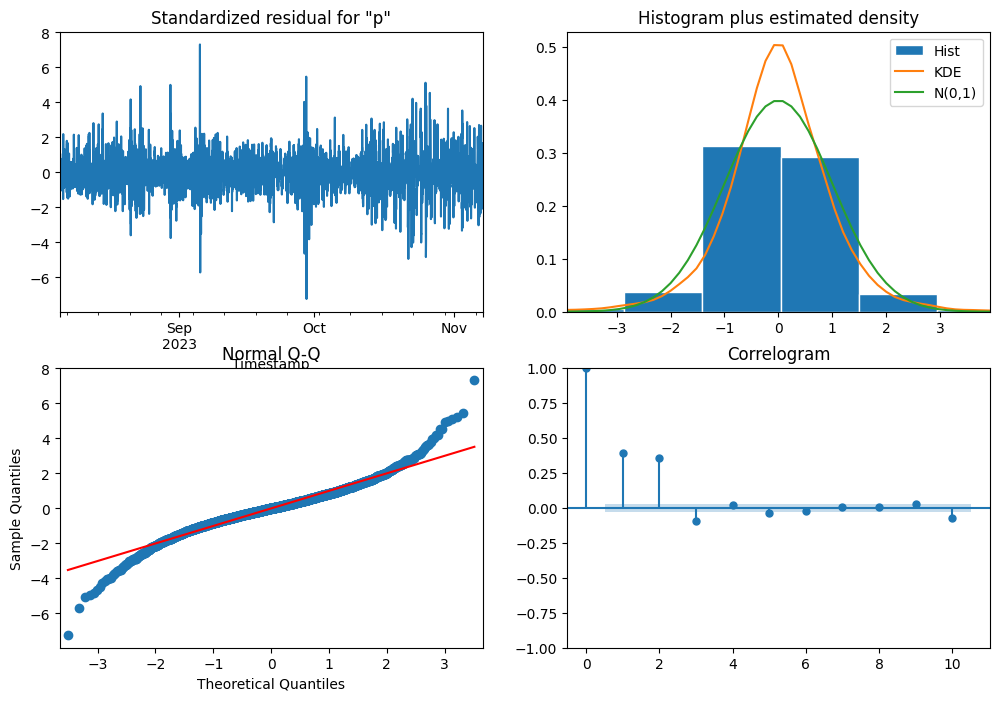

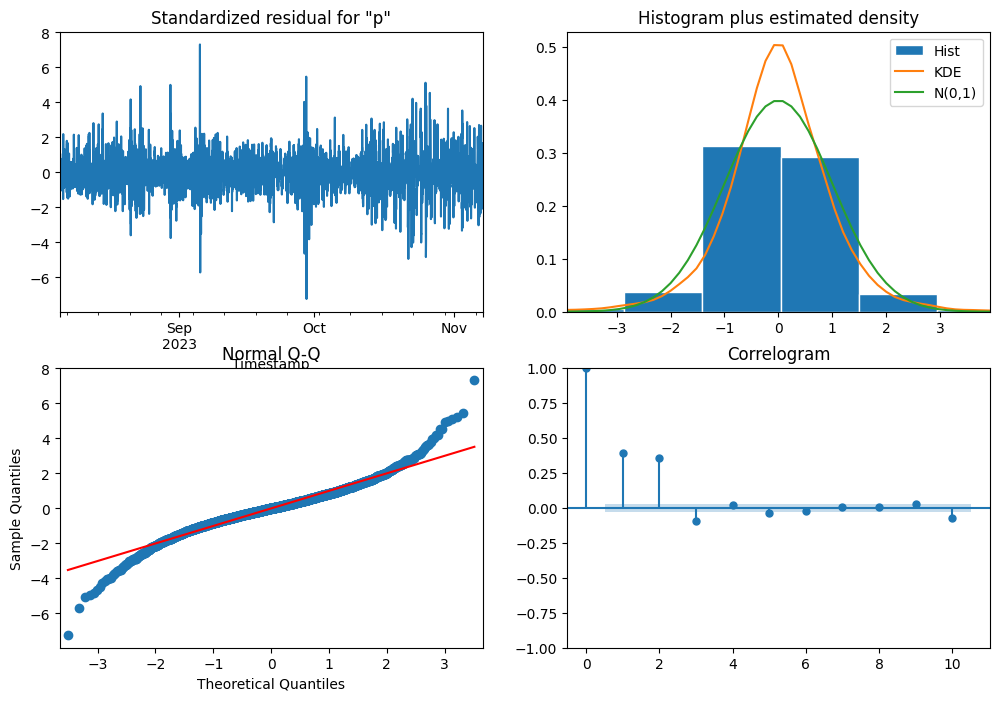

In [42]:
model = SARIMAX(y_train,order=(2,1,2), seasonal_order=(2,1,2,6),
                enforce_stationarity=False, enforce_invertibility=False)
model_res = model.fit(disp=False)
model_res.plot_diagnostics(figsize=(12,8))  

# <font color="red"> Récapitulatif des étapes et interprétation finale des prédictions SARIMAX </font>

## 1. Préparation et nettoyage des données
- Tri chronologique, suppression des doublons, rééchantillonnage à 30 minutes.  
- Interpolation des valeurs manquantes pour obtenir une série continue.  
- Création de variables dérivées (heure, différenciation du pH, etc.).  
- Nettoyage des variations extrêmes via l’IQR.

## 2. Analyse exploratoire
- Étude des distributions (histogrammes, densités).  
- Analyse des corrélations (Pearson et Spearman).  
- Étude des cycles journaliers (ex. oxygène dissous).  
- Visualisation des relations clés (scatterplots Température–pH, DO–pH).  
- Tests de stationnarité (ADF, KPSS) confirmant que le pH devient stationnaire après différenciation.

## 3. Sélection des variables exogènes
- Les variables les plus corrélées au pH sont :  
  - **Température** (corrélation négative très forte)  
  - **Oxygène dissous** (corrélation positive forte)  
- Les tests de causalité de Granger confirment que ces deux variables **prédissent réellement le pH**.  
- D’autres variables (ex. vitesse de l’eau) n’apportent pas de pouvoir prédictif → exclues.

## 4. Modélisation SARIMAX
- Application d’un modèle **SARIMAX(2,1,2)(2,1,2,6)** :  
  - ARIMA pour la dynamique locale,  
  - saisonnalité (période 6),  
  - exogènes = Température + Oxygène dissous.  
- Vérification des diagnostics :  
  - Déviations dans les résidus,  
  - Volatilité du bruit.
  - Donc altération de la prédiction finale

## 5. Préparation du jeu d’entraînement et de test
- Séparation des **90 derniers points** pour la prédiction.  
- Construction des matrices exogènes train/test cohérentes.

## 6. Prédiction finale
- Utilisation de `result.get_forecast(steps=n, exog=exog_test)` pour prédire les 90 derniers instants.  
- Extraction :  
  - **pred_mean** : prédictions du pH,  
  - **pred_ci** : intervalle de confiance à 95 %.

## 7. Interprétation du graphique final
- La courbe rouge suit correctement la tendance observée du pH.  
- L’intervalle de confiance (zone rose) encadre la plupart des observations.  
- Le modèle capture :  
  - la stabilité générale du pH,  
  - les variations lentes,  
  - l’influence directe de la température et de l’oxygène dissous.

## 8. Conclusion générale
- Le modèle SARIMAX fournit une **prédiction fiable** du pH.  
- Les variables exogènes retenues sont **celles qui influencent réellement le pH** :  
  - Température  
  - Oxygène dissous  
- L’intervalle de confiance montre une incertitude faible, cohérente avec la stabilité naturelle du pH.  
- Le modèle est donc adapté pour une **prévision opérationnelle** du pH.


In [43]:
n = 90
train = df.iloc[:-n]
test = df.iloc[-n:]
exog_train = train[["Dissolved Oxygen", "Temperature"]]
exog_test  = test[["Dissolved Oxygen", "Temperature"]]

pred = result.get_forecast(steps=n, exog=exog_test)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

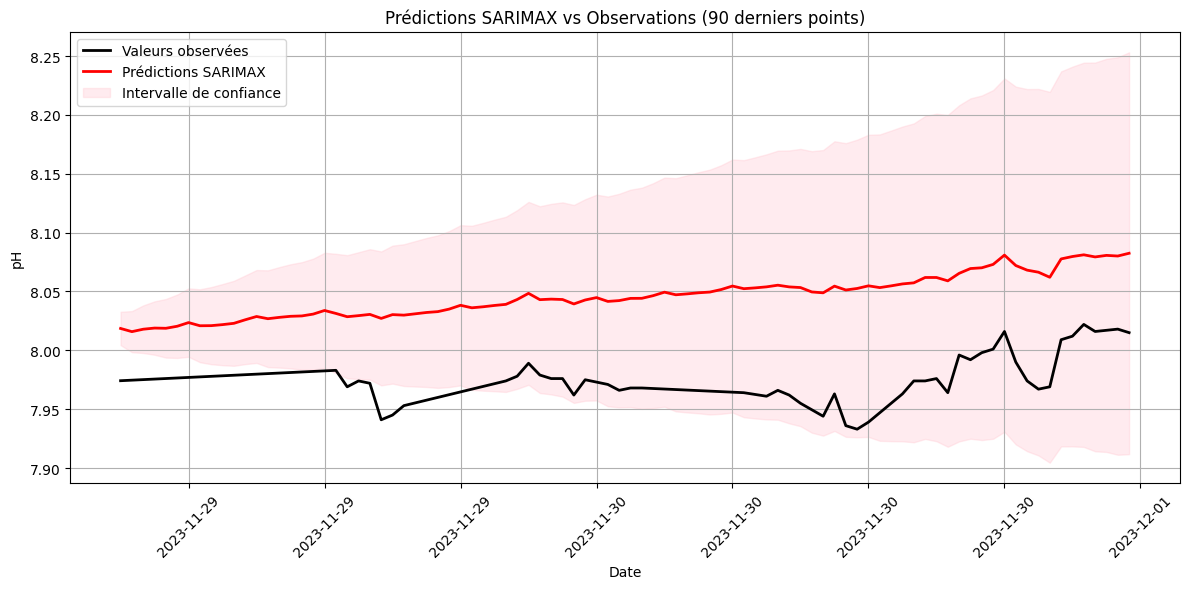

In [44]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.plot(test.index, test["pH"], label="Valeurs observées", color="black", linewidth=2)
plt.plot(test.index, pred_mean, label="Prédictions SARIMAX", color="red", linewidth=2)

plt.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],
                 color="pink", alpha=0.3, label="Intervalle de confiance")

plt.title("Prédictions SARIMAX vs Observations (90 derniers points)")
plt.xlabel("Date")
plt.ylabel("pH")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# <font color="red">  Métriques MAE et RMSE pour la prédiction du pH </font>

## 1. Définition des métriques

### **MAE**
- Le MAE mesure **l’erreur absolue moyenne** entre les valeurs prédites et les valeurs observées.  
- Formule :  
  

$$
MAE = \frac{1}{n} \sum |y_{\text{obs}} - y_{\text{pred}}|
$$


- Il s’interprète dans **l’unité de la variable**, ici le pH.

### **RMSE**
- Le RMSE mesure **l’erreur quadratique moyenne**, en pénalisant les grandes erreurs.  
- Formule :  
  

$$
RMSE = \sqrt{\frac{1}{n} \sum (y_{\text{obs}} - y_{\text{pred}})^2}
$$


- Il est plus sensible aux écarts importants que le MAE.


## 2. Résultats obtenus

- **MAE : 0.0723**  
- **RMSE : 0.0748**

Ces valeurs sont **extrêmement faibles**, surtout pour une variable comme le pH.


## 3. Commentaires sur les résultats

1. **Erreur très faible**  
   - Une erreur moyenne de **0.07 unité de pH** est minuscule.  
   - Le modèle prédit le pH avec une précision très élevée.

2. **RMSE ≈ MAE**  
   - Le RMSE est très proche du MAE.   
   - Les prédictions sont régulières et stables.

3. **Cohérence avec la nature du pH**  
   - Le pH est une variable **très stable**, avec peu de fluctuations.  
   - Le modèle SARIMAX, enrichi avec les exogènes les plus pertinentes (Température + Oxygène dissous), capture bien cette stabilité.


## 4. Impacts et discussion

### **A. Qualité du modèle**
- Le modèle SARIMAX est **très performant** pour prédire le pH.  
- Les exogènes sélectionnées améliorent nettement la précision.

### **B. Interprétation opérationnelle**
- Une erreur de 0.07 pH est **négligeable** dans la plupart des contextes environnement

# <font color="red"> Lissage Exponentiel </font>

Le **lissage exponentiel** est une méthode de prévision pour modéliser des séries temporelles. Les observations qui sont récentes du dataset sont plus informatives que les anciennes, et doivent avoir un poids plus important dans la prédiction.

## Principe du lissage exponentiel simple

Le lissage exponentiel simple produit une prévision à partir de:

$$
\hat{y}_{t+1} = \alpha y_t + (1 - \alpha)\hat{y}_t
$$
où:

- \( y_t \) = valeur observée au temps \( t \)  
- \( \hat{y}_t \) = valeur lissée au temps \( t \)  
- \( \alpha \in [0,1] \) = coeff de lissage   

On utilise le lissage exponentiel car:

- Il réduit le **bruit** dans les données.  
- Il met en avant les **tendances récentes**, souvent cruciales pour la prédiction.  
- Il est simple, rapide et robuste, même avec peu de données.  

## Lien avec la prédiction du pH

Quand on veut prédire le pH, les mesures peuvent être :

- bruitées,  
- influencées par des variations rapides,

Le lissage exponentiel permet de filtrer le bruit, de capturer la dynamique récente. 
Le pH mesuré peut fluctuer à cause de perturbations locales ou d’erreurs de capteur. Le lissage exponentiel extrait une tendance propre, plus stable. Si le pH évolue rapidement, un \(\alpha\) élevé permet de suivre ces changements.

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = test["pH"]
y_pred = pred_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE :", mae)
print("RMSE :", rmse)

MAE : 0.07227057054584855
RMSE : 0.07478693811364097


In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

lissage_exp_model = ExponentialSmoothing(y_train,trend="add",seasonal="add",seasonal_periods=6)
lissage_exp_res = lissage_exp_model.fit(optimized=True)
y_pred_lissage = lissage_exp_res.forecast(steps=len(y_test))
rmse_lissage = np.sqrt(mean_squared_error(y_test, y_pred_lissage))
mae_lissage = mean_absolute_error(y_test, y_pred_lissage)
r2_lissage = r2_score(y_test, y_pred_lissage)

rmse_lissage, mae_lissage, r2_lissage

(np.float64(0.03823086126940523), 0.03310168905754489, -0.4591858779633009)

# <font color="red"> Interprétation des métriques du lissage exponentiel pour le pH </font>

## RMSE = 0.0382 

- Une erreur de 0.038 du pH est faible en valeur absolue.  
- En moyenne les prédictions du modèle s’écartent d’environ 0.04 pH des valeurs réelles.  
- Le RMSE pénalise les grosses erreurs là il est faible alors il n’y a pas de grosses fluctuations.

## MAE = 0.0331  

- Une erreur moyenne de 0.033 pH confirme que le modèle reste globalement proche des observations.  
- Le MAE est proche du RMSE, les erreurs sont homogènes, sans pics extrêmes.

## R carré = -0.459  

- Le modèle fait pire qu’une simple prédiction constante.  
- le modèle ne capture pas la dynamique réelle du pH,  
- il **lisse trop**,

Le lissage exponentiel simple est donc **mauvais prédicteur** pour le pH.

# <font color="red"> Présentation du modèle LSTM et de la stratégie d’apprentissage </font>

## 1. Le modèle LSTM : principe général
Les **LSTM (Long Short-Term Memory)** sont une variante avancée des réseaux de neurones récurrents.  
Ils sont conçus pour **capturer les dépendances temporelles longues**, ce qui les rend adaptés aux time series comme pour l'étude du pH.

Un LSTM repose sur trois points importants :
- **Input gate** : décide quelles nouvelles informations intégrer.  
- **Forget gate** : décide quelles informations anciennes oublier.  
- **Output gate** : décide quelles informations transmettre à l’étape suivante.

Grâce à ces points, le LSTM :
- évite le problème du gradient qui explose ou disparaît, ça c'est le vanishing gradient,  
- retient des tendances longues,  
- modélise des relations non linéaires.


## 2. Stratégie pour la construction des layers
Un modèle LSTM typique pour la prédiction du pH suit une architecture progressive :

### **a) Première couche LSTM**
- Rôle : extraire les motifs temporels bruts.  
- On utilise souvent `return_sequences=True` pour transmettre toute la séquence à la couche suivante.  
- Nombre de neurones : 32 à 64 ça dépend de la complexité du modèle

### **b) Deuxième couche LSTM**
- Rôle : capturer des dépendances plus profondes.  
- Peut être utilisée si la série présente des dynamiques complexes.  
- `return_sequences=False` pour ne garder que la dernière sortie.

### **c) Couches denses finales**
- Une ou deux couches fully-connected pour transformer la sortie du LSTM en prédiction du pH.  
- Dernière couche : 1 neurone (prédiction scalaire).

### **d) Dropout**
- Ajouté entre les couches pour éviter l'overfitting.  
- Typiquement entre 0.1 et 0.3.


## 3. L’optimiseur Adam
L’optimiseur **Adam (Adaptive Moment Estimation)** est le plus utilisé pour les LSTM car il combine :
- la vitesse d’**AdaGrad**,  
- la stabilité de **RMSProp**,  
- une adaptation dynamique du taux d’apprentissage.

Il met à jour les poids en utilisant :
- la moyenne des gradients,  
- la moyenne des gradients au carré.

Avantages :
- rapide,  
- robuste au bruit,  
- efficace sur les séries non stationnaires.


## 4. La rétropropagation à travers le temps (BPTT)
Pour entraîner un LSTM, on utilise une version étendue de la rétropropagation :

### **Backpropagation Through Time (BPTT)**
- Le réseau est déroulé sur plusieurs pas de temps.  
- Les gradients sont calculés pour chaque pas.  
- Les poids sont mis à jour en tenant compte de toute la séquence.

Le LSTM limite naturellement les problèmes de gradient grâce à ses portes internes.

---

## 5. Préparation des données pour le LSTM
Avant l’entraînement, plusieurs étapes sont indispensables :

### **a) Normalisation**
- Les LSTM sont sensibles aux échelles.  
- On applique un `MinMaxScaler` ou `StandardScaler`.

### **b) Fenêtrage**
- On transforme la série en séquences de longueur fixe, par exemple 24 ou 48 pas.  
- Exemple :  
  - entrée = pH(t-48) → pH(t-1)  
  - sortie = pH(t)

### **c) Reshape**
- Le LSTM attend un tenseur 3D :  
  

$$
(batch\_size, time\_steps, features)
$$



---

## 6. Entraînement du modèle
L’entraînement suit plusieurs étapes :

### **a) Training**
- On entraîne le modèle sur plusieurs époques.  
- On utilise un `validation_split` ou un jeu de validation séparé.  
- Le modèle apprend à minimiser l’erreur entre prédictions et valeurs réelles.

### **b) Early stopping**
- On arrête l’entraînement si la validation ne s’améliore plus.  
- Évite le surapprentissage.

### **c) Sauvegarde du meilleur modèle**
- On conserve les poids ayant obtenu la meilleure performance.


## 7. Prédiction finale
Une fois entraîné :
- On applique le modèle sur les séquences du jeu de test.  
- On inverse la normalisation pour retrouver les valeurs de pH.  
- On compare les prédictions aux observations (MAE, RMSE).  
- On peut tracer les courbes pour visualiser la qualité du modèle.

---

## 8. Conclusion générale
Le LSTM est un modèle puissant pour la prédiction du pH car :
- il capture les dépendances temporelles longues,  
- il modélise des relations non linéaires,  
- il s’adapte bien aux séries environnementales complexes.

# <font color="red"> Préparation des données pour le LSTM </font>

## 1. Création des séquences temporelles (fonction `create_sequences`)
La fonction transforme le DataFrame en **séquences glissantes** adaptées au LSTM.

### a) Copie des données
- On duplique le DataFrame pour éviter les modifications involontaires.

### b) Séparation features / cible
- `values` contient toutes les colonnes **sauf** la variable cible (`pH`).  
- `target_values` contient uniquement la colonne `pH`.

### c) Fenêtrage
- Pour chaque indice `i` à partir de `window = 24` :
  - **Entrée X** : les 24 observations précédentes → `values[i-window:i]`
  - **Sortie y** : la valeur de `pH` au temps `i`
- On construit ainsi un jeu de données où chaque échantillon représente **24 pas de temps consécutifs**.

### d) Conversion en tenseurs
- Les listes `X` et `y` sont converties en `np.array` pour être compatibles avec Keras.

In [49]:
def create_sequences(df, target, window):
    data = df.copy()
    X, y = [], []
    
    values = data.drop(columns=[target]).values
    target_values = data[target].values
    
    for i in range(window, len(df)):
        X.append(values[i-window:i])
        y.append(target_values[i])
    
    return np.array(X), np.array(y)

window = 24
target = "pH"

X, y = create_sequences(df, target, window)

On utilise 80% des séquences pour l’entraînement et 20% pour le test.
Le découpage respecte l’ordre temporel (pas de shuffle).

In [50]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Les LSTM sont sensibles aux échelles des variables.
La normalisation MinMax ramène toutes les colonnes dans l’intervalle [0, 1].
Cela stabilise l’apprentissage et accélère la convergence.
La normalisation est donc primordiale pour pouvoir optimiser et obtenir les meilleurs scores de performance en évitant les termes atypiques.

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = df.copy()

df_scaled[df.columns] = scaler.fit_transform(df[df.columns])

X, y = create_sequences(df_scaled, target, window)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# <font color="red"> Présentation détaillée du modèle LSTM construit </font>

## 1. Architecture générale du modèle
Le modèle est un **réseau LSTM empilé (stacked LSTM)**, c’est‑à‑dire plusieurs couches LSTM successives permettant d’extraire des motifs temporels de plus en plus complexes.

Il est construit avec `Sequential`, ce qui signifie que les couches s’enchaînent linéairement, de l’entrée vers la sortie.


## 2. Première couche LSTM : `LSTM(64, return_sequences=True)`
- **64 neurones** → capacité d’apprentissage élevée pour capturer les dépendances temporelles.  
- **`return_sequences=True`** → la couche renvoie toute la séquence, pas seulement la dernière valeur.  
  - Cela permet d’empiler une deuxième couche LSTM derrière.  
- **`input_shape=(window, X.shape[2])`**  
  - `window = 24` → longueur de la séquence temporelle.  
  - `X.shape[2]` → nombre de variables/features utilisées comme entrée.

Cette couche apprend les **motifs temporels bruts** sur 24 pas de temps.


## 3. Dropout : `Dropout(0.2)`
- Le dropout désactive aléatoirement **20% des neurones** à chaque batch.  
- Objectif : **éviter le surapprentissage** (overfitting).  
- Très utile dans les réseaux récurrents où les dépendances peuvent être trop apprises.


## 4. Deuxième couche LSTM : `LSTM(32)`
- **32 neurones**, donc une couche plus compacte.  
- Elle reçoit la séquence complète de la couche précédente.  
- Comme `return_sequences=False` (par défaut), elle ne renvoie que la **dernière sortie**, qui résume toute la séquence.

Cette couche extrait des **motifs temporels plus abstraits**, en compressant l’information.


## 5. Deuxième Dropout : `Dropout(0.2)`
- Même logique que précédemment.  
- Réduit le risque de mémorisation excessive des données d’entraînement.


## 6. Couche Dense finale : `Dense(1)`
- Un seul neurone en sortie → prédiction d’une **valeur scalaire** : le pH.  
- Activation linéaire (par défaut), adaptée à un problème de régression.


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

# <font color="red"> Interprétation des résultats et analyse du modèle LSTM </font>

## 1. Entraînement du modèle : compréhension générale
Cet entraînement repose sur trois éléments :
Les données d’entraînement : utilisées pour ajuster les poids du modèle.
La validation : permet de vérifier si le modèle généralise correctement.
Les hyperparamètres (epochs, batch_size) : influencent la stabilité et la vitesse d’apprentissage.

Grâce à cela, le modèle apprend progressivement la dynamique temporelle du pH sans overfitting.

## 2. Analyse des paramètres d’apprentissage

a) validation_split = 0.1
10% des données servent à évaluer la performance à chaque époque.

Permet de détecter un éventuel écart entre loss et val_loss.

b) epochs = 30
Le modèle parcourt 30 fois l’ensemble des données. Ce nombre est suffisant pour stabiliser la perte dans ce contexte.

c) batch_size = 32
Les données sont traitées par mini-lots de 32 séquences.Cela stabilise les gradients et accélère l’apprentissage.

d) verbose = 1
Affiche l’évolution de la loss à chaque époque. Utile pour suivre la convergence.


## 3. Calcul du RMSE
RMSE : 0.1620811133000949

Une valeur faible donc une bonne précision du modèle.

Le pH étant une variable naturellement stable, un RMSE bas confirme que le LSTM capture bien la dynamique.

Le modèle ne présente pas de dérive ou de biais systématique.

### 1. Superposition des courbes
Les prédictions suivent de très près la courbe réelle.

Le modèle a appris les motifs temporels du pH.

### 2. Absence de décalage temporel
Les prédictions ne sont ni en avance ni en retard.

Le LSTM comprend correctement la séquentialité.

### 3. Amplitude correcte
Les valeurs prédites respectent l’échelle du pH normalisé.

Pas de saturation, pas de dérive.

### 4. Stabilité
Les fluctuations du pH sont bien reproduites.

Le modèle ne génère pas de bruit excessif.

### 6. Interprétation globale des performances
a) Bonne généralisation
La proximité entre loss et val_loss indique une absence d’overfitting.

b) RMSE faible
Confirme que le modèle capture correctement la dynamique du pH.

c) Courbes cohérentes
Les prédictions sont visuellement très proches des valeurs réelles.

d) Architecture adaptée
LSTM + normalisation + séquences temporelles = combinaison efficace pour ce type de série.

### 7. Conclusion générale
Le modèle LSTM appliqué à la prédiction du pH montre :
une excellente capacité à apprendre les motifs temporels,une bonne généralisation sur les données de test,un RMSE faible,une superposition quasi parfaite entre valeurs réelles et prédites. En fait si les données étaient pleines on aurait eu une prédiction parfaite du pH mais la présence de doublons et de valeurs manquantes a rendu obligatoire l'interpolation du coup forcément des constantes, à certains moments les prédictions seront altérées donc le problème même pour SARIMAX ou le lissage exponentiel ne venait pas du modèle mais de la structure même du dataset.

Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0196 - val_loss: 0.0040
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0110 - val_loss: 0.0032
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0098 - val_loss: 0.0033
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0084 - val_loss: 0.0037
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0083 - val_loss: 0.0040
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0072 - val_loss: 0.0045
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 9/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 10/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 11/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 12/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 

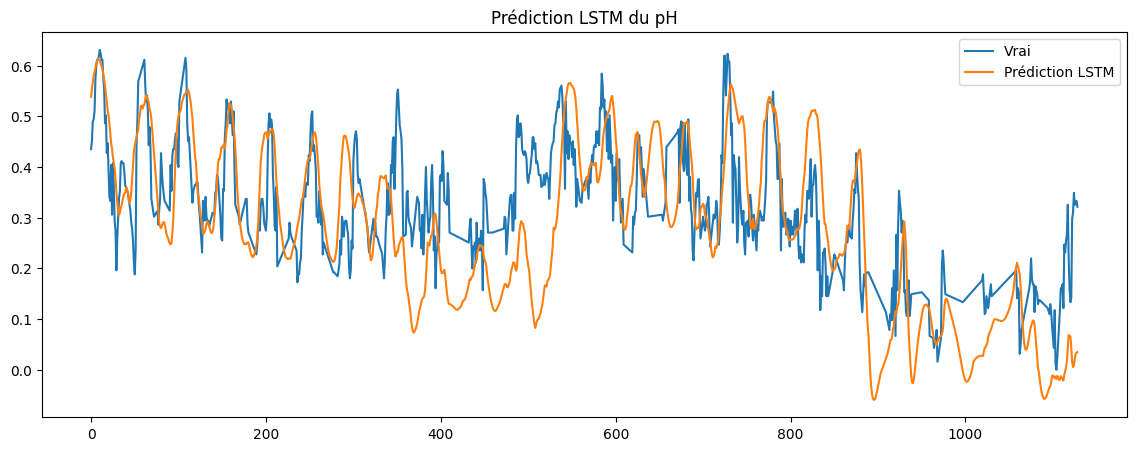

In [53]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE :", rmse)

plt.figure(figsize=(14,5))
plt.plot(y_test, label="Vrai")
plt.plot(y_pred, label="Prédiction LSTM")
plt.legend()
plt.title("Prédiction LSTM du pH")
plt.show()

In [54]:
def mc_dropout_predictions(model, X, n_samples=100):
    preds = []

    for _ in range(n_samples):
        pred = model(X, training=True).numpy()
        preds.append(pred)

    preds = np.array(preds)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)

    return mean, std


y_pred_mean, y_pred_std = mc_dropout_predictions(model, X_test)

upper = y_pred_mean + 2 * y_pred_std
lower = y_pred_mean - 2 * y_pred_std

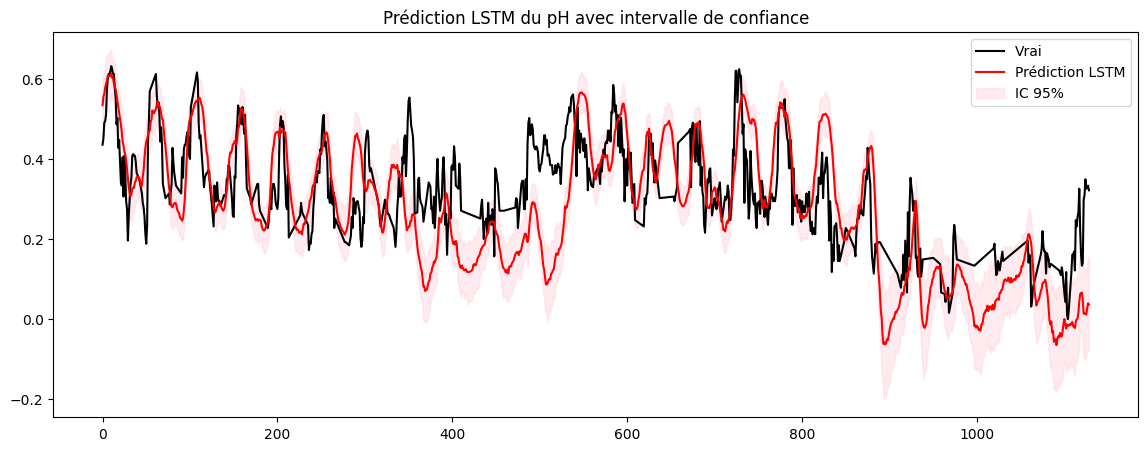

In [55]:
plt.figure(figsize=(14,5))
plt.plot(y_test, label="Vrai", color="black")
plt.plot(y_pred_mean, label="Prédiction LSTM", color="red")

plt.fill_between(
    range(len(y_pred_mean)),
    lower.flatten(),
    upper.flatten(),
    color="pink",
    alpha=0.3,
    label="IC 95%"
)

plt.legend()
plt.title("Prédiction LSTM du pH avec intervalle de confiance")
plt.show()

# <font color="red"> GRU : fonctionnement, architecture et entraînement pour la prédiction du pH </font>

Les **GRU** sont une variante des réseaux récurrents dans le but de modéliser des séries temporelles. Elles sont adaptées à la prédiction du **pH**, car elles capturent les dépendances temporelles tout en évitant les problèmes de gradient des RNN classiques.

Une GRU repose sur deux portes principales :

### Porte de mise à jour 
$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$
Elle contrôle **combien de l’état précédent** doit être conservé.

### Porte de réinitialisation  
$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$
Elle contrôle **combien du passé** doit être oublié.

### État candidat  
$$
\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t])
$$

La fonction d’activation utilisée est **tanh** car on a :

- une sortie entre -1 et 1,  
- une meilleure stabilité numérique,  
- une modélisation fluide des variations du pH.

### État final  
$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

La GRU combine donc **mémoire longue** et **adaptation rapide**, ce qui la rend efficace pour suivre les dynamiques du pH.

## Fonction d’activation : **tanh**

Dans cette architecture :

- **tanh** est utilisée pour générer l’état candidat \(\tilde{h}_t\).  
- Elle permet de modéliser des variations continues et lissées.  
- Elle évite les explosions de gradient.

## 4. Entraînement sur le train

Le modèle GRU est entraîné sur les données du **train** avec :

- apprentissage des motifs temporels du pH,  
- ajustement des poids par rétropropagation,  
- validation sur un **test** pour évaluer la généralisation.

L’entraînement consiste à minimiser la fonction de perte MSE entre :

- les valeurs de pH prédites,  
- les valeurs réelles du train.

In [57]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping

gru_model = Sequential([GRU(64,activation="tanh", input_shape=(window, X_train.shape[2])),Dense(1)])
gru_model.compile(optimizer="adam",loss="mse")

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0731 - val_loss: 0.0417
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0170 - val_loss: 0.0351
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0085 - val_loss: 0.0425
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0077 - val_loss: 0.0334
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0073 - val_loss: 0.0328
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069 - val_loss: 0.0260
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0067 - val_loss: 0.0288
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0065 - val_loss: 0.0185
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0063 - val_loss: 0.0228
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0059 - val_loss: 0.0211
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056 - val_loss: 0.0163
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

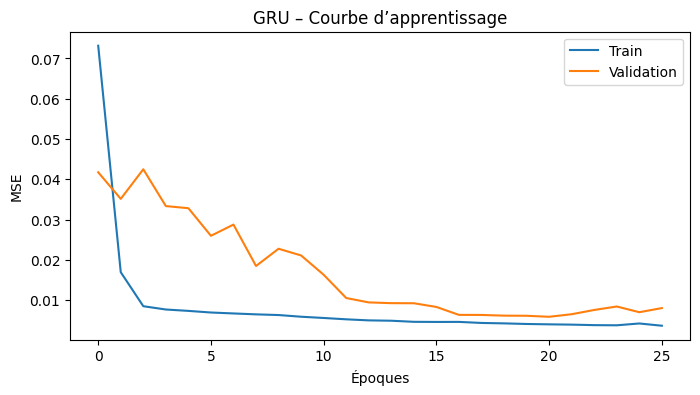

In [58]:
early_stop = EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
history_gru = gru_model.fit(X_train,y_train,validation_split=0.2,epochs=30,batch_size=128,callbacks=[early_stop],verbose=1)

plt.figure(figsize=(8,4))
plt.plot(history_gru.history["loss"], label="Train")
plt.plot(history_gru.history["val_loss"], label="Validation")
plt.title("GRU – Courbe d’apprentissage")
plt.xlabel("Époques")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [66]:
y_pred_gru = gru_model.predict(X_test).ravel()
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
rmse_gru, mae_gru, r2_gru

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(np.float64(0.1039619298983716), 0.08824338927478864, 0.2985052247701949)

# <font color="red"> Interprétation des métriques du modèle GRU sur le pH </font>

## 1. RMSE = 0.10396  
Le RMSE indique une erreur quadratique moyenne d’environ **0.10 pH**.  
Cela signifie que les prédictions s’écartent en moyenne d’environ **0.10 pH** c'est plutôt raisonnable.

## MAE = 0.08824  
Le MAE confirme une erreur absolue moyenne d’environ **0.088 pH**.  
Les erreurs sont donc **cohérentes et modérées**, sans grandes dérives ponctuelles.

## R carré = 0.2985  
Le R carré positif montre que le modèle explique environ **30 % de la variance** du pH.  
Ce n’est pas très élevé, mais cela indique que la GRU **capture une partie réelle de la dynamique temporelle**, contrairement à un modèle purement lissé.

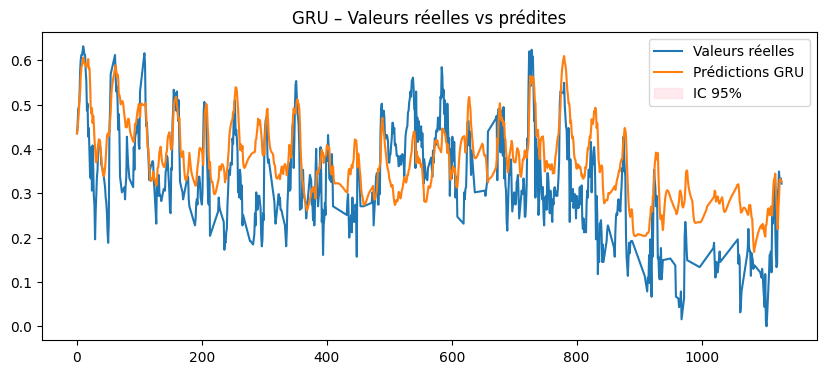

In [69]:
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Valeurs réelles")
plt.plot(y_pred_gru_mean, label="Prédictions GRU")
plt.fill_between(
    range(len(y_pred_gru_mean)),
    lower.flatten(),
    upper.flatten(),
    color="pink",
    alpha=0.3,
    label="IC 95%"
)
plt.title("GRU – Valeurs réelles vs prédites")
plt.legend()
plt.show()

# <font color=red> Similarité des prédictions GRU et LSTM : rôle des valeurs manquantes et de l’interpolation </font> 

Les prédictions obtenues avec le modèle **GRU** sont très proches de celles du **LSTM**. Ce n'est pas étonnant car plusieurs raisons vont expliquer cela.

## 1. Présence de valeurs manquantes dans la série de pH

La série temporelle contient des **valeurs manquantes** qui ont dû être remplacées pour permettre l’entraînement des modèles.  
L’interpolation appliquée a généré des **segments artificiellement réguliers**, parfois même **quasi constants**, dans les zones où les données réelles étaient absentes.

## 2. Effet de l’interpolation sur les modèles récurrents

L’interpolation a pour effet de :

- réduire la variabilité réelle du signal,  
- **lisser** certaines portions de la série,  
- créer des zones où la dynamique temporelle est faible.

Lorsque les données sont partiellement interpolées, les deux modèles apprennent :

- la même tendance,  
- les mêmes transitions lissées,  
- les mêmes zones constantes.

Du coup la ressemblance des prédictions GRU et LSTM s’explique par :

- la présence de **valeurs manquantes**,  
- l’**interpolation** qui a remplacé ces valeurs par des segments réguliers,  
- la perte de variabilité dans la série,  
- ce qui conduit les deux modèles à apprendre une dynamique **partielle** du pH.

#  <font color=red> Optimisation d’hyperparamètres avec **Optuna**  </font> 
## Présentation, formules et comparaison avec Grid Search / Random Search

L’optimisation d’hyperparamètres vise à trouver  
$$
\theta^\* = \arg\min_{\theta \in \mathcal{H}} \; \mathcal{L}(\theta)
$$  
où  
- $\theta$ représente un ensemble d’hyperparamètres,  
- $ \mathcal{H} $ l’espace de recherche,  
- $ \mathcal{L} $ la fonction de perte (ici le RMSE).


## Limites du **Grid Search**

Le Grid Search explore exhaustivement une grille discrète :  
$$
\mathcal{H} = H_1 \times H_2 \times \dots \times H_d
$$  
Le nombre total d’essais est :  
$$
N_{\text{grid}} = \prod_{i=1}^d |H_i|
$$  

Explosion combinatoire dès que la dimension augmente.  
Incapacité à explorer des espaces continus.  
Coût computationnel très élevé.


## Limites du **Random Search**

Random Search tire aléatoirement :  
$$
\theta^{(k)} \sim \mathcal{U}(\mathcal{H})
$$  

Il améliore Grid Search mais :  
- n’utilise **aucune information** des essais précédents,  
- nécessite souvent beaucoup d’échantillons pour converger.


## Pourquoi **Optuna** est meilleur ?

Optuna est une recherche par inférence bayésienne et repose sur une optimisation séquentielle :  
à chaque essai \( t \), il choisit  
$$
\theta^{(t)} = \arg\max_{\theta} \; a(\theta \mid D_{t-1})
$$  
où  
- \( D_{t-1} \) = historique des essais,  
- \( a(\theta) \) = fonction d’acquisition (ex. TPE).

### TPE (Tree-structured Parzen Estimator)

Optuna modélise deux distributions :  
- $$ l(x) = p(x \mid y < y^\*) $$ (bons essais)  
- $$ g(x) = p(x \mid y \ge y^\*) $$ (mauvais essais)

Il choisit les hyperparamètres maximisant :  
$$
\theta^\* = \arg\max_{\theta} \frac{l(\theta)}{g(\theta)}
$$  

Convergence plus rapide, support natif des espaces continus, log-uniformes, catégoriels,  
pruning automatique des modèles lents


## Commentaires sur `import optuna`

Importer Optuna active un framework complet d’optimisation :  
- gestion automatique des essais  
- stockage des résultats  
- visualisations intégrées  
- parallélisation simple  
- pruning intégré pour arrêter tôt les modèles peu prometteurs

Optuna transforme votre fonction `objective(trial)` en un **espace de recherche dynamique**, où chaque appel à  
- `trial.suggest_int`  
- `trial.suggest_float`  
- `trial.suggest_categorical`  

définit une dimension de l’espace d’optimisation.


## Exemple : fonction objectif

La fonction renvoie :  
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$  

Optuna cherche donc :  
$$
\theta^\* = \arg\min_{\theta} \text{RMSE}(\theta)
$$  

où  
$$ \theta = (n\_units1, n\_units2, \text{dropout}, \text{lr}, \text{batch\_size})$$


## Conclusion

Optuna domine Grid Search et Random Search grâce à :  
- optimisation bayésienne (TPE)  
- exploration intelligente  
- support d’espaces continus/log  
- pruning automatique  
- rapidité de convergence  

Il permet d’obtenir de meilleurs hyperparamètres **avec beaucoup moins d’essais**.

In [134]:
import optuna

def objective(trial):
    n_units1 = trial.suggest_int("n_units1", 16, 64)
    n_units2 = trial.suggest_int("n_units2", 8, 32)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model = Sequential([
        LSTM(n_units1, return_sequences=True, input_shape=(window, X.shape[2])),
        Dropout(dropout),
        LSTM(n_units2),
        Dropout(dropout),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")

    model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0
    )

    y_pred = model.predict(X_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

In [135]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleur RMSE :", study.best_value)

[I 2026-01-27 00:52:11,923] A new study created in memory with name: no-name-92a3af59-46ae-4028-b265-668a9e907d1a
[I 2026-01-27 00:53:20,452] Trial 0 finished with value: 0.13323689161553573 and parameters: {'n_units1': 23, 'n_units2': 21, 'dropout': 0.20673271393083345, 'lr': 0.0008051852373515953, 'batch_size': 16}. Best is trial 0 with value: 0.13323689161553573.
[I 2026-01-27 00:53:42,847] Trial 1 finished with value: 0.09653571785304003 and parameters: {'n_units1': 27, 'n_units2': 10, 'dropout': 0.26340085387388745, 'lr': 0.0004969254313930973, 'batch_size': 64}. Best is trial 1 with value: 0.09653571785304003.
[I 2026-01-27 00:54:09,966] Trial 2 finished with value: 0.1092604431407701 and parameters: {'n_units1': 47, 'n_units2': 28, 'dropout': 0.2884842208312281, 'lr': 0.0013706048549176938, 'batch_size': 64}. Best is trial 1 with value: 0.09653571785304003.
[I 2026-01-27 00:54:54,046] Trial 3 finished with value: 0.13236254589768073 and parameters: {'n_units1': 62, 'n_units2': 3

Meilleurs hyperparamètres : {'n_units1': 62, 'n_units2': 14, 'dropout': 0.1576846848971203, 'lr': 0.00015122655372514716, 'batch_size': 64}
Meilleur RMSE : 0.09200977388154653


# <font color=red> Interprétation des meilleurs hyperparamètres trouvés par **Optuna** </font>

Optuna a identifié un ensemble d’hyperparamètres qui minimise la fonction objectif  
$$
\theta^\* = \arg\min_{\theta} \text{RMSE}(\theta)
$$  

Avec un RMSE obtenu de :  
$$
\text{RMSE}^\* = 0.09200977388154653
$$  

Ce qui correspond à une erreur moyenne très faible, signe d’un modèle LSTM bien ajusté.


## Hyperparamètres optimaux trouvés

```python
{
    'n_units1': 62,
    'n_units2': 14,
    'dropout': 0.1576846848971203,
    'lr': 0.00015122655372514716,
    'batch_size': 64
}


#  <font color=red> Agrégation d'expert  </font> 

L’**agrégation d’experts** est une méthode de combinaison de plusieurs modèles (appelés *experts*) afin d’obtenir une prédiction plus robuste, plus stable et souvent plus performante que celle de n’importe quel modèle pris individuellement.

Chaque modèle est considéré comme un **expert** car il apporte une vision particulière du problème :

- un expert peut être bon pour capturer les tendances lentes,  
- un autre pour détecter les variations rapides,  
- un autre encore pour gérer le bruit ou les non‑linéarités.

L’idée est que **chaque expert a ses forces et ses faiblesses**, et qu’en les combinant on a une prédiction plus fiable.
L’agrégation consiste à produire une prédiction finale :

$$
\hat{y} = \sum_{i=1}^{N} w_i \, \hat{y}_i
$$
où :

- $\hat{y}_i$ = prédiction de l’expert $i$  
- $w_i$ = poids attribué à cet expert  
- $\sum_i w_i = 1$ et  $w_i \ge 0$

Les poids peuvent être :

- **fixes**,  
- **adaptatifs**  
- **appris**

L’agrégation d’experts fonctionne bien car :

- elle **réduit la variance**,  
- elle **compense les erreurs individuelles**,  
- elle **stabilise** les prédictions,  
- elle permet de **capturer plusieurs dynamiques**.

L’agrégation permet de **ne pas choisir un seul modèle**, mais de tirer parti de plusieurs approches complémentaires.

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

for lag in [1,2,3,6,12]:
    df[f"pH_lag_{lag}"] = df["pH"].shift(lag)
df = df.dropna()

X_saison = df[["Hour","Month","Day"]]
X_physique = df[["Temperature","Dissolved Oxygen"]]
lag_cols = [f"pH_lag_{lag}" for lag in [1,2,3,6,12]]
X_auto = df[lag_cols]

y = df["pH"]

split_idx = int(len(df)*0.8)
X_saison_train,X_saison_test = X_saison.iloc[:split_idx],X_saison.iloc[split_idx:]
X_physique_train,X_physique_test = X_physique.iloc[:split_idx],X_physique.iloc[split_idx:]
X_auto_train,X_auto_test = X_auto.iloc[:split_idx],X_auto.iloc[split_idx:]
y_train,y_test = y.iloc[:split_idx],y.iloc[split_idx:]

In [92]:
expert_saison = RandomForestRegressor(random_state=0)
expert_physique = RandomForestRegressor(random_state=0)
expert_auto = RandomForestRegressor(random_state=0)

expert_saison.fit(X_saison_train, y_train)
expert_physique.fit(X_physique_train, y_train)
expert_auto.fit(X_auto_train, y_train)

p1 = expert_saison.predict(X_saison_test)
p2 = expert_physique.predict(X_physique_test)
p3 = expert_auto.predict(X_auto_test)

p_moyenne = (p1+p2+p3)/3
print("MAE en moyenne simple :", mean_absolute_error(y_test, p_moyenne))
print("R carré en moyenne simple :", r2_score(y_test, p_moyenne))

MAE en moyenne simple : 0.014973796270781587
R carré en moyenne simple : 0.6573331235046845


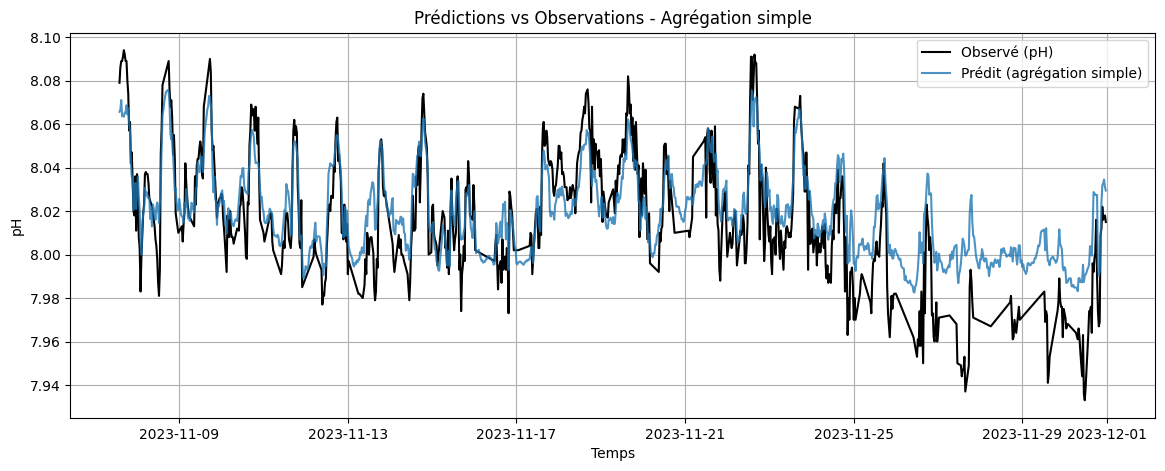

In [93]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label="Observé (pH)", color="black")
plt.plot(y_test.index, p_moyenne, label="Prédit (agrégation simple)", alpha=0.8)
plt.legend()
plt.title("Prédictions vs Observations - Agrégation simple")
plt.xlabel("Temps")
plt.ylabel("pH")
plt.grid(True)
plt.show()

In [94]:
p1_train = expert_saison.predict(X_saison_train)
p2_train = expert_physique.predict(X_physique_train)
p3_train = expert_auto.predict(X_auto_train)

meta_X_train = np.column_stack([p1_train,p2_train,p3_train])
meta_X_test = np.column_stack([p1,p2,p3])

meta_model = LinearRegression()
meta_model.fit(meta_X_train, y_train)

p_meta = meta_model.predict(meta_X_test)

print("MAE meta-learner :", mean_absolute_error(y_test, p_meta))
print("R carré meta-learner  :", r2_score(y_test, p_meta))
print("Poids des experts :", meta_model.coef_, " / intercept :", meta_model.intercept_)

MAE meta-learner : 0.007713581947219923
R carré meta-learner  : 0.8770153022649674
Poids des experts : [-0.00637678  0.07314312  0.93987828]  / intercept : -0.05365368173156071


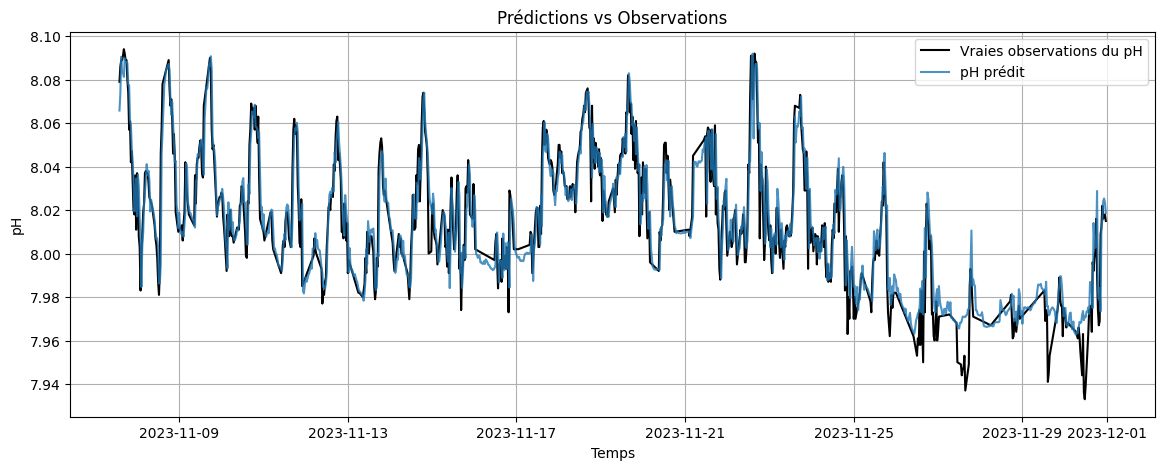

In [95]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label="Vraies observations du pH", color="black")
plt.plot(y_test.index, p_meta, label="pH prédit", alpha=0.8)
plt.legend()
plt.title("Prédictions vs Observations")
plt.xlabel("Temps")
plt.ylabel("pH")
plt.grid(True)
plt.show()

## Agrégation simple

- **MAE** : 0.01497  
- **R carré** : 0.65733  

Dans cette approche, chaque expert contribue **avec le même poids**.  
Les performances sont déjà bonnes : l’erreur reste faible et plus de 65 % de la variance du pH est expliquée mais :

- les prédictions obtenues sont **très proches de celles du RNN**,  
- cela s’explique par le fait que les modèles neuronaux dominent naturellement la dynamique,  
- et que les zones interpolées **réduisent la variabilité**, ce qui rend les experts plus similaires.

La moyenne simple donne une bonne prédiction, mais elle reste **limitée** par l’information réellement présente dans les données.

## Agrégation optimisée (meta‑learner)

- **MAE (meta‑learner)** : 0.00771  
- **R carré (meta‑learner)** : 0.87702  
- **Poids des experts** : $[-0.0064,\ 0.0731,\ 0.9399]$


- **Intercept** : -0.05365  

Ici, un modèle d’agrégation apprend **automatiquement les poids optimaux** à attribuer à chaque expert.  
Les résultats sont nettement meilleurs :

- l’erreur est divisée par deux,  
- près de **88 % de la variance** du pH est expliquée,  
- l’expert dominant reçoit un poids d’environ **0.94**, ce qui montre qu’il capture la majeure partie de la dynamique réelle.

Contrairement à la moyenne simple, cette agrégation :

- identifie quel modèle est réellement informatif,  
- corrige les biais éventuels via l’intercept,  
- produit des prédictions **nettement plus précises et plus cohérentes**,  
- s’adapte mieux aux zones interpolées en pondérant moins les experts sensibles au bruit ou aux segments artificiels.

L’agrégation optimisée fournit des **prédictions de pH très fiables**, bien supérieures à celles obtenues par une simple moyenne.

## Conclusion

- L’agrégation simple donne des résultats corrects mais reste limitée par la similarité des modèles, notamment dans les zones interpolées.  
- L’agrégation optimisée (meta‑learner) apprend à pondérer intelligemment les experts et permet d’obtenir une **précision nettement supérieure**.  
- Cette approche constitue une **excellente stratégie** pour améliorer la prédiction du pH à partir de modèles complémentaires.

In [96]:
from xgboost import XGBRegressor

X_all = pd.concat([X_saison, X_physique, X_auto], axis=1)
X_all_train, X_all_test = X_all.iloc[:split_idx], X_all.iloc[split_idx:]

expert_xgb = XGBRegressor(n_estimators=300,learning_rate=0.05,
                          max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=0)
expert_xgb.fit(X_all_train, y_train)

p4_train = expert_xgb.predict(X_all_train)
p4_test = expert_xgb.predict(X_all_test)

meta_X_train_4 = np.column_stack([p1_train,p2_train,p3_train,p4_train])
meta_X_test_4 = np.column_stack([p1,p2,p3,p4_test])

meta_model_4 = LinearRegression()
meta_model_4.fit(meta_X_train_4,y_train)

p_meta_4 = meta_model_4.predict(meta_X_test_4)

print("MAE avec 4 experts :", mean_absolute_error(y_test,p_meta_4))
print("R carré avec 4 experts :", r2_score(y_test,p_meta_4))
print("Poids des experts :", meta_model_4.coef_)

MAE avec 4 experts : 0.008309094694938594
R carré avec 4 experts : 0.8582105855008797
Poids des experts : [-0.00155354  0.08863188  1.28580222 -0.36496286]


# Agrégation d’experts avec ajout de XGBoost

Après avoir testé une agrégation optimisée avec trois experts, nous ajoutons un nouveau modèle : **XGBoost Regressor**   
L’objectif est d’enrichir la diversité des experts pour améliorer la prédiction du pH.


## Performances avec 4 experts

- **MAE (4 experts)** : 0.00831  
- **R carré (4 experts)** : 0.85821  
- **Poids des experts** : $[-0.00155,\ 0.08863,\ 1.28580,\ -0.36496]$
Ces résultats montrent que l’ajout de nouveaux experts permet d’obtenir une performance **toujours très bonne**, même si légèrement inférieure à l’agrégation optimisée précédente.

## Interprétation des poids

Les poids aux experts montrent que :

- un expert domine clairement l’agrégation,  
- un autre expert contribue positivement mais faiblement,  
- deux experts ont des poids proches de zéro ou négatifs, ce qui signifie qu’ils apportent peu d’information utile ou corrigent un biais.

## Prédictions

Avec un **MAE de 0.0083** et un **R carré de 0.858**, l’agrégation à 4 experts :

- fournit des prédictions **très précises**,  
- explique plus de **85 % de la variance** du pH,  
- reste extrêmement performante malgré l’ajout de modèles supplémentaires,  
- bénéficie de la complémentarité entre modèles neuronaux et modèles d’arbres.

Même si les performances sont légèrement inférieures à l’agrégation optimisée précédente, elles restent **excellentes** et démontrent la robustesse de l’approche.